<a href="https://colab.research.google.com/github/CodeHunterOfficial/ABC_DataMining/blob/main/TatarNLP/tat_monocorpus_v2Lora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install datasets transformers accelerate bitsandbytes matplotlib sacrebleu huggingface_hub wandb torch

In [ ]:
import transformers,  datasets, torch, huggingface_hub, matplotlib, bitsandbytes, accelerate, sacrebleu, wandb
print("Всё установлено!")

In [ ]:
import peft
print('Ok')

In [ ]:
print(52)

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # отключаем GPU

from datasets import load_dataset
from transformers import AutoTokenizer

print("Загрузка датасета...")
ds = load_dataset("IPSAN/tat_monocorpus_v2", split="train")
print(f"Датасет загружен, размер: {len(ds)}")

# Загружаем токенизатор
tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token

def tokenize_small(examples):
    # Правильно: обрабатываем все тексты в батче
    return tokenizer(
        examples["txt"],           # список всех текстов в батче
        truncation=True,
        padding="max_length",
        max_length=256
    )

print("Токенизация 10000 примеров (батчами по 1000)...")
small = ds.select(range(10000)).map(
    tokenize_small,
    batched=True,
    batch_size=1000,
    remove_columns=ds.column_names
)
print("✅ Токенизация 10000 примеров выполнена")
print(f"Размер токенизированного датасета: {len(small)}")
print(f"Пример: {small[0]['input_ids'][:10]}...")

In [ ]:
print(251)

251


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
tat_pipeline_final_rf_fixed_full.py

ФИНАЛЬНАЯ ВЕРСИЯ для научной статьи:
- Полный датасет Tat Monocorpus (230k)
- Модели: GPT family, Qwen, DeepSeek, Mistral (LoRA/QLoRA)
- Статистическая значимость (NUM_SEEDS)
- Кэширование токенизации, возобновление экспериментов
- Логирование в файл, защита от сбоев
- АВТОМАТИЧЕСКОЕ СКАЧИВАНИЕ АРХИВА В ЛОКАЛЬНЫЙ КОМПЬЮТЕР
"""

import os
import json
import csv
import math
import gc
import time
import sys
import logging
import zipfile
import shutil
import warnings
from datetime import datetime
from pathlib import Path

import torch
import psutil
import matplotlib.pyplot as plt
import numpy as np

# Проверка наличия необходимых библиотек
try:
    from datasets import load_dataset, DatasetDict, load_from_disk
    from transformers import (
        AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments,
        DataCollatorWithPadding, BitsAndBytesConfig, set_seed
    )
    from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, TaskType
    from huggingface_hub import login
    from IPython.display import FileLink, display, Javascript
except ImportError as e:
    print(f"Ошибка импорта: {e}")
    print("Убедитесь, что установлены: transformers datasets peft accelerate bitsandbytes huggingface-hub matplotlib psutil ipython")
    sys.exit(1)

# ======================= КОНФИГУРАЦИЯ =======================
HF_TOKEN = ""  # ваш токен
DATASET_ID = "IPSAN/tat_monocorpus_v2"
SUBSET_SIZE = 1000                     # None = все данные (230k)
TRUNCATE_CHARS = 2000
MAX_LENGTH = 128
TOKENIZE_BATCH_SIZE = 500
TOKENIZE_NUM_PROC = min(4, max(1, (os.cpu_count() or 4) - 1))
SEED = 42
NUM_SEEDS = 3                           # для статистической значимости (>1)

LEARNING_RATE = 2e-4
GRADIENT_ACCUMULATION_STEPS = 2
LOGGING_STEPS = 50
EPOCHS_BASE = 3
EPOCHS_LARGE = 2                        # для 7B моделей
RESULTS_BASE = "./tat_results_final_rf"

# Проверка свободного места (минимум 20 ГБ)
free_space = shutil.disk_usage(".").free / (1024**3)
if free_space < 20:
    print(f"⚠️  Предупреждение: на диске всего {free_space:.1f} ГБ. Рекомендуется минимум 20 ГБ.")

# --- Список экспериментов (LLaMA удалена) ---
EXPERIMENTS = [
    # DistilGPT2
    {"name": "distilgpt2_baseline", "model_name": "distilgpt2",
     "use_lora": False, "batch_size": 8, "epochs": EPOCHS_BASE, "tokenizer_group": "gpt2", "fp16": False},
    {"name": "distilgpt2_lora_r8", "model_name": "distilgpt2",
     "use_lora": True, "lora_r": 8, "lora_alpha": 16, "lora_dropout": 0.05,
     "target_modules": ["c_attn"], "batch_size": 8, "epochs": EPOCHS_BASE, "tokenizer_group": "gpt2", "fp16": True},
    {"name": "distilgpt2_lora_r16", "model_name": "distilgpt2",
     "use_lora": True, "lora_r": 16, "lora_alpha": 32, "lora_dropout": 0.05,
     "target_modules": ["c_attn"], "batch_size": 8, "epochs": EPOCHS_BASE, "tokenizer_group": "gpt2", "fp16": True},

    # GPT2
    {"name": "gpt2_baseline", "model_name": "gpt2",
     "use_lora": False, "batch_size": 8, "epochs": EPOCHS_BASE, "tokenizer_group": "gpt2", "fp16": False},
    {"name": "gpt2_lora_r8", "model_name": "gpt2",
     "use_lora": True, "lora_r": 8, "lora_alpha": 16, "lora_dropout": 0.05,
     "target_modules": ["c_attn"], "batch_size": 8, "epochs": EPOCHS_BASE, "tokenizer_group": "gpt2", "fp16": True},
    {"name": "gpt2_lora_r16", "model_name": "gpt2",
     "use_lora": True, "lora_r": 16, "lora_alpha": 32, "lora_dropout": 0.05,
     "target_modules": ["c_attn"], "batch_size": 8, "epochs": EPOCHS_BASE, "tokenizer_group": "gpt2", "fp16": True},

    # GPT2-medium
    {"name": "gpt2-medium_baseline", "model_name": "gpt2-medium",
     "use_lora": False, "batch_size": 4, "epochs": EPOCHS_BASE, "tokenizer_group": "gpt2", "fp16": False},
    {"name": "gpt2-medium_lora_r8", "model_name": "gpt2-medium",
     "use_lora": True, "lora_r": 8, "lora_alpha": 16, "lora_dropout": 0.05,
     "target_modules": ["c_attn"], "batch_size": 4, "epochs": EPOCHS_BASE, "tokenizer_group": "gpt2", "fp16": True},
    {"name": "gpt2-medium_lora_r16", "model_name": "gpt2-medium",
     "use_lora": True, "lora_r": 16, "lora_alpha": 32, "lora_dropout": 0.05,
     "target_modules": ["c_attn"], "batch_size": 4, "epochs": EPOCHS_BASE, "tokenizer_group": "gpt2", "fp16": True},

    # Qwen2.5-7B
    {"name": "qwen2.5_qlora_r8", "model_name": "Qwen/Qwen2.5-7B-Instruct",
     "use_lora": True, "use_qlora": True, "lora_r": 8, "lora_alpha": 16, "lora_dropout": 0.05,
     "target_modules": ["q_proj", "v_proj", "k_proj", "o_proj"],
     "batch_size": 1, "epochs": EPOCHS_LARGE, "tokenizer_group": "qwen", "fp16": True},
    {"name": "qwen2.5_qlora_r16", "model_name": "Qwen/Qwen2.5-7B-Instruct",
     "use_lora": True, "use_qlora": True, "lora_r": 16, "lora_alpha": 32, "lora_dropout": 0.05,
     "target_modules": ["q_proj", "v_proj", "k_proj", "o_proj"],
     "batch_size": 1, "epochs": EPOCHS_LARGE, "tokenizer_group": "qwen", "fp16": True},

    # DeepSeek-7B
    {"name": "deepseek_qlora_r8", "model_name": "deepseek-ai/deepseek-llm-7b-chat",
     "use_lora": True, "use_qlora": True, "lora_r": 8, "lora_alpha": 16, "lora_dropout": 0.05,
     "target_modules": ["q_proj", "v_proj", "k_proj", "o_proj"],
     "batch_size": 1, "epochs": EPOCHS_LARGE, "tokenizer_group": "deepseek", "fp16": True},
    {"name": "deepseek_qlora_r16", "model_name": "deepseek-ai/deepseek-llm-7b-chat",
     "use_lora": True, "use_qlora": True, "lora_r": 16, "lora_alpha": 32, "lora_dropout": 0.05,
     "target_modules": ["q_proj", "v_proj", "k_proj", "o_proj"],
     "batch_size": 1, "epochs": EPOCHS_LARGE, "tokenizer_group": "deepseek", "fp16": True},

    # Mistral-7B
    {"name": "mistral_qlora_r8", "model_name": "mistralai/Mistral-7B-v0.3",
     "use_lora": True, "use_qlora": True, "lora_r": 8, "lora_alpha": 16, "lora_dropout": 0.05,
     "target_modules": ["q_proj", "v_proj", "k_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
     "batch_size": 1, "epochs": EPOCHS_LARGE, "tokenizer_group": "mistral", "fp16": True},
    {"name": "mistral_qlora_r16", "model_name": "mistralai/Mistral-7B-v0.3",
     "use_lora": True, "use_qlora": True, "lora_r": 16, "lora_alpha": 32, "lora_dropout": 0.05,
     "target_modules": ["q_proj", "v_proj", "k_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
     "batch_size": 1, "epochs": EPOCHS_LARGE, "tokenizer_group": "mistral", "fp16": True},
]

# ======================= НАСТРОЙКА ЛОГИРОВАНИЯ =======================
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_folder = Path(RESULTS_BASE) / f"run_{timestamp}"
results_folder.mkdir(parents=True, exist_ok=True)

log_file = results_folder / "experiment.log"
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(log_file, encoding='utf-8'),
        logging.StreamHandler(sys.stdout)
    ]
)
logger = logging.getLogger(__name__)

logger.info(f"Результаты будут сохранены в: {results_folder}")

# ======================= ПРОВЕРКА УСТРОЙСТВА =======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Устройство: {device}")
logger.info(f"Доступная RAM: {psutil.virtual_memory()}")
if torch.cuda.is_available():
    try:
        logger.info(f"GPU: {torch.cuda.get_device_name(0)}")
        logger.info(f"Память GPU: {torch.cuda.get_device_properties(0).total_memory / 1e9} GB")
    except Exception as e:
        logger.warning(f"Не удалось получить информацию о GPU: {e}")

if HF_TOKEN:
    try:
        login(token=HF_TOKEN)
        logger.info("Успешный вход в Hugging Face Hub")
    except Exception as e:
        logger.error(f"Ошибка входа: {e}")

# ======================= 1. ЗАГРУЗКА ДАННЫХ =======================
logger.info(f"1. Загрузка датасета {DATASET_ID}...")
ds = load_dataset(DATASET_ID, split="train", token=HF_TOKEN if HF_TOKEN else None)
logger.info(f"Всего записей: {len(ds)}")

if SUBSET_SIZE is not None and SUBSET_SIZE < len(ds):
    subset = ds.select(range(SUBSET_SIZE))
    logger.info(f"Используется {SUBSET_SIZE} записей (подвыборка)")
else:
    subset = ds
    logger.info(f"Используется полный датасет ({len(subset)} записей)")

TEXT_COL = None
for col in ["text", "content", "sentence", "article", "utterance", "txt"]:
    if col in subset.column_names:
        TEXT_COL = col
        break
if TEXT_COL is None:
    TEXT_COL = subset.column_names[0]
logger.info(f"Колонка с текстом: {TEXT_COL}")

def truncate_batch(batch):
    return {TEXT_COL: [t[:TRUNCATE_CHARS] if t else "" for t in batch[TEXT_COL]]}

logger.info(f"Обрезка текстов до {TRUNCATE_CHARS} символов...")
subset = subset.map(truncate_batch, batched=True, batch_size=1000)

logger.info("Разделение на train/val/test...")
train_val = subset.train_test_split(test_size=0.10, seed=SEED)
val_test = train_val["test"].train_test_split(test_size=0.5, seed=SEED)
dataset = DatasetDict({
    "train": train_val["train"],
    "eval": val_test["train"],
    "test": val_test["test"]
})
logger.info(f"Размеры: { {k: len(dataset[k]) for k in dataset} }")
dataset.save_to_disk(str(results_folder / "raw_subset"))
logger.info("Сырой датасет сохранён.")

# ======================= 2. ТОКЕНИЗАЦИЯ С КЭШИРОВАНИЕМ =======================
def prepare_tokenizer(model_group):
    if model_group == "gpt2":
        tok = AutoTokenizer.from_pretrained("distilgpt2")
    elif model_group == "qwen":
        tok = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-7B-Instruct", trust_remote_code=True)
    elif model_group == "deepseek":
        tok = AutoTokenizer.from_pretrained("deepseek-ai/deepseek-llm-7b-chat", trust_remote_code=True)
    elif model_group == "mistral":
        tok = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.3", trust_remote_code=True)
    else:
        tok = AutoTokenizer.from_pretrained("distilgpt2")
    if tok.pad_token is None:
        tok.pad_token = tok.eos_token
    return tok

def create_tokenize_fn(tokenizer, text_column):
    """Фабрика функций токенизации с защитой от пустых текстов."""
    def tokenize_fn(examples):
        texts = []
        for t in examples[text_column]:
            if t is None or str(t).strip() == "":
                texts.append(" ")   # один пробел даст один токен
            else:
                texts.append(str(t))
        out = tokenizer(
            texts,
            truncation=True,
            max_length=MAX_LENGTH,
            padding=False,
            return_attention_mask=True
        )
        # labels — копия input_ids; делаем списки чтобы избежать вложенных типов
        out["labels"] = [list(ids) for ids in out["input_ids"]]
        return out
    return tokenize_fn

tokenizer_map = {}
tokenized_map = {}

# Конфигурация токенизации для проверки кэша
tokenization_config = {
    "MAX_LENGTH": MAX_LENGTH,
    "TRUNCATE_CHARS": TRUNCATE_CHARS,
    "TEXT_COL": TEXT_COL,
    "DATASET_SIZE": len(dataset["train"]) + len(dataset["eval"]) + len(dataset["test"])
}

all_columns = dataset["train"].column_names
logger.info(f"Исходные колонки датасета: {all_columns}")

# Определяем группы токенизаторов (LLaMA удалена)
groups = ["gpt2", "qwen", "deepseek", "mistral"]

for group in groups:
    tokenizer = prepare_tokenizer(group)
    tokenizer_map[group] = tokenizer
    tokenized_path = results_folder / f"tokenized_{group}"
    tokenized_config_path = tokenized_path / "tokenization_config.json"

    # Проверяем, есть ли уже токенизированный датасет и совпадает ли конфиг
    if tokenized_path.exists() and tokenized_config_path.exists():
        with open(tokenized_config_path, "r", encoding="utf-8") as f:
            saved_config = json.load(f)
        if saved_config == tokenization_config:
            logger.info(f"Загрузка токенизированного датасета {group} из {tokenized_path}")
            tokenized_map[group] = load_from_disk(str(tokenized_path))
            continue
        else:
            logger.info(f"Конфигурация токенизации для {group} изменилась, перетокенизация...")
    else:
        logger.info(f"Токенизация для {group}...")

    # Токенизируем
    tokenized = dataset.map(
        create_tokenize_fn(tokenizer, TEXT_COL),
        batched=True,
        batch_size=TOKENIZE_BATCH_SIZE,
        num_proc=1 if group in ["qwen", "deepseek", "mistral"] else TOKENIZE_NUM_PROC,
        remove_columns=all_columns,
    )
    tokenized.save_to_disk(str(tokenized_path))
    with open(tokenized_config_path, "w", encoding="utf-8") as f:
        json.dump(tokenization_config, f, indent=2)
    tokenized_map[group] = tokenized
    logger.info(f"Токенизированный датасет ({group}) сохранён.")

# ======================= 3. ВСПОМОГАТЕЛЬНЫЕ ФУНКЦИИ =======================
def cleanup():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

def compute_ppl(loss):
    try:
        return math.exp(loss)
    except Exception:
        return None

def get_batch_candidates(initial_bs):
    candidates = []
    bs = initial_bs
    while True:
        candidates.append(max(1, int(bs)))
        if bs == 1:
            break
        bs = bs // 2
    return candidates

# ======================= КАСТОМНЫЙ COLLATOR =======================
class DataCollatorForCausalLMWithLabelPad:
    def __init__(self, tokenizer, label_pad_token_id: int = -100, pad_to_multiple_of: int = None):
        self.tokenizer = tokenizer
        self.label_pad_token_id = label_pad_token_id
        self.base_collator = DataCollatorWithPadding(tokenizer, padding=True, return_tensors="pt",
                                                     pad_to_multiple_of=pad_to_multiple_of)

    def __call__(self, features):
        allowed_keys = ["input_ids", "attention_mask", "labels"]
        filtered_features = [{k: f[k] for k in allowed_keys if k in f} for f in features]
        labels = [f.pop("labels") if "labels" in f else None for f in filtered_features]
        batch = self.base_collator(filtered_features)
        if any(l is not None for l in labels):
            max_len = batch["input_ids"].shape[1]
            padded_labels = []
            for l in labels:
                if l is None:
                    padded = [self.label_pad_token_id] * max_len
                else:
                    l = list(l)
                    if len(l) < max_len:
                        padded = l + [self.label_pad_token_id] * (max_len - len(l))
                    else:
                        padded = l[:max_len]
                padded_labels.append(padded)
            batch["labels"] = torch.tensor(padded_labels, dtype=torch.long)
        return batch

# ======================= 4. ЗАПУСК ЭКСПЕРИМЕНТА (с возобновлением) =======================
def experiment_already_done(exp_name, seed_val, results_dir):
    """Проверяет, выполнен ли уже эксперимент с данным seed."""
    marker_file = results_dir / exp_name / f"seed{seed_val}" / "done.txt"
    return marker_file.exists()

def run_experiment(exp_cfg, tokenized_data, tokenizer, results_dir, seed_val):
    name = exp_cfg["name"]
    model_name = exp_cfg["model_name"]
    use_lora = exp_cfg.get("use_lora", False)
    use_qlora = exp_cfg.get("use_qlora", False)
    use_fp16 = exp_cfg.get("fp16", True)
    initial_bs = exp_cfg.get("batch_size", 8)
    epochs = exp_cfg.get("epochs", 1)

    # Если уже выполнен, возвращаем пустой результат (пропускаем)
    if experiment_already_done(name, seed_val, results_dir):
        logger.info(f"Эксперимент {name} (seed={seed_val}) уже выполнен, пропускаем.")
        return {"skipped": True, "name": name, "seed": seed_val}

    def _fmt(val, fmt="{:.4f}"):
        try:
            return fmt.format(val) if val is not None else "None"
        except Exception:
            try:
                return str(val)
            except Exception:
                return "None"

    batch_candidates = get_batch_candidates(initial_bs)
    result = {
        "name": name,
        "model_name": model_name,
        "seed": seed_val,
        "attempts": [],
        "config": exp_cfg.copy()
    }
    start_total = time.time()

    for bs in batch_candidates:
        logger.info(f"--- Попытка {name} (seed={seed_val}) с batch_size={bs} ---")
        attempt_start = time.time()
        if torch.cuda.is_available():
            try:
                torch.cuda.reset_peak_memory_stats()
            except Exception:
                pass

        model = None
        trainer = None
        try:
            load_kwargs = {
                "low_cpu_mem_usage": True,
                "trust_remote_code": True,
                "token": HF_TOKEN
            }

            if use_qlora:
                bnb_config = BitsAndBytesConfig(
                    load_in_4bit=True,
                    bnb_4bit_use_double_quant=True,
                    bnb_4bit_quant_type="nf4",
                    bnb_4bit_compute_dtype=torch.float16
                )
                load_kwargs["quantization_config"] = bnb_config
                load_kwargs["device_map"] = "auto"
            else:
                if use_fp16 and torch.cuda.is_available():
                    load_kwargs["torch_dtype"] = torch.float16
                else:
                    load_kwargs["torch_dtype"] = torch.float32

            logger.info(f"Загрузка модели: {model_name}")
            try:
                model = AutoModelForCausalLM.from_pretrained(model_name, **load_kwargs)
            except Exception as e:
                logger.error(f"Не удалось загрузить модель {model_name}: {e}")
                result["attempts"].append({"batch_size": bs, "status": "load_error", "error": str(e)[:200]})
                break  # переходим к следующему batch size? но если модель не грузится, все batch size бесполезны

            # --- LoRA/PEFT ---
            trainable_params = None
            if use_lora:
                if use_qlora:
                    model = prepare_model_for_kbit_training(model)
                target_modules = exp_cfg.get("target_modules")
                if target_modules is None:
                    target_modules = ["c_attn"] if "gpt2" in model_name.lower() else ["q_proj", "v_proj"]
                lora_config = LoraConfig(
                    r=exp_cfg["lora_r"],
                    lora_alpha=exp_cfg["lora_alpha"],
                    target_modules=target_modules,
                    lora_dropout=exp_cfg.get("lora_dropout", 0.0),
                    bias="none",
                    task_type=TaskType.CAUSAL_LM
                )
                model = get_peft_model(model, lora_config)
                try:
                    trainable_params = model.num_parameters(only_trainable=True)
                except Exception:
                    trainable_params = None
            else:
                if not hasattr(model, "hf_device_map"):
                    model = model.to(device)
                try:
                    model.gradient_checkpointing_enable()
                except Exception:
                    pass

            output_dir = results_dir / name / f"seed{seed_val}" / f"bs{bs}"
            output_dir.mkdir(parents=True, exist_ok=True)

            optim = "adamw_8bit" if use_qlora else "adamw_torch"

            training_args = TrainingArguments(
                output_dir=str(output_dir),
                per_device_train_batch_size=bs,
                per_device_eval_batch_size=bs,
                gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
                learning_rate=LEARNING_RATE,
                num_train_epochs=epochs,
                logging_steps=LOGGING_STEPS,
                eval_strategy="steps",
                eval_steps=LOGGING_STEPS,
                save_strategy="no",
                report_to="none",
                fp16=(use_fp16 and torch.cuda.is_available()),
                gradient_checkpointing=True,
                optim=optim,
                seed=seed_val,  # используем переданный seed
                remove_unused_columns=True,
                dataloader_num_workers=0,
                ddp_find_unused_parameters=False if use_lora else None,
            )

            data_collator = DataCollatorForCausalLMWithLabelPad(
                tokenizer=tokenizer,
                label_pad_token_id=-100,
                pad_to_multiple_of=8
            )

            trainer = Trainer(
                model=model,
                args=training_args,
                train_dataset=tokenized_data["train"],
                eval_dataset=tokenized_data["eval"],
                data_collator=data_collator,
            )

            try:
                trainer.train()
            except RuntimeError as e:
                msg = str(e).lower()
                if "out of memory" in msg or ("cuda" in msg and "memory" in msg):
                    logger.warning(f"OOM при batch_size={bs}, пробуем меньший...")
                    result["attempts"].append({"batch_size": bs, "status": "oom", "error": str(e)[:200]})
                    try:
                        del trainer
                    except:
                        pass
                    try:
                        del model
                    except:
                        pass
                    cleanup()
                    continue
                else:
                    raise

            if use_lora:
                adapter_save_path = output_dir / "adapter"
                model.save_pretrained(adapter_save_path)
                logger.info(f"Адаптер сохранён в {adapter_save_path}")

            try:
                with open(output_dir / "log_history.json", "w", encoding="utf-8") as f:
                    json.dump(getattr(trainer.state, "log_history", []), f, indent=2, ensure_ascii=False)
            except Exception as e_log:
                logger.warning(f"Не удалось сохранить log_history: {e_log}")

            eval_metrics = {}
            try:
                eval_metrics = trainer.evaluate(eval_dataset=tokenized_data["test"])
            except Exception as e_eval:
                logger.warning(f"Ошибка при evaluate: {e_eval}")

            test_loss = eval_metrics.get("eval_loss") if isinstance(eval_metrics, dict) else None
            test_ppl = compute_ppl(test_loss) if test_loss is not None else None

            peak_gpu_mem = None
            if torch.cuda.is_available():
                try:
                    peak_gpu_mem = torch.cuda.max_memory_allocated() / 1e9
                except Exception:
                    peak_gpu_mem = None

            elapsed = time.time() - attempt_start

            loss_str = _fmt(test_loss, "{:.4f}")
            ppl_str = _fmt(test_ppl, "{:.2f}")
            gpu_str = _fmt(peak_gpu_mem, "{:.2f}")

            logger.info(f"✅ Успех! Loss={loss_str}, PPL={ppl_str}, время={elapsed:.1f}с, пик GPU={gpu_str}GB")

            result.update({
                "status": "success",
                "batch_size": bs,
                "test_loss": test_loss,
                "test_perplexity": test_ppl,
                "trainable_params": trainable_params,
                "peak_gpu_memory_gb": peak_gpu_mem,
                "time_seconds": elapsed,
                "total_time_seconds": time.time() - start_total
            })
            result["attempts"].append({
                "batch_size": bs,
                "status": "success",
                "eval_loss": test_loss,
                "perplexity": test_ppl,
                "time_seconds": elapsed
            })

            # Помечаем seed-эксперимент как выполненный (независимо от batch_size)
            seed_dir = results_dir / name / f"seed{seed_val}"
            seed_dir.mkdir(parents=True, exist_ok=True)
            with open(seed_dir / "done.txt", "w") as f:
                f.write(f"success with batch_size={bs}")

            try:
                del trainer
            except:
                pass
            try:
                del model
            except:
                pass
            cleanup()
            return result

        except Exception as e:
            logger.error(f"Ошибка при batch_size={bs}: {e}")
            result["attempts"].append({"batch_size": bs, "status": "error", "error": str(e)[:200]})
            try:
                del model
            except:
                pass
            try:
                del trainer
            except:
                pass
            cleanup()
            continue

    result["status"] = "failed_all_bs"
    result["total_time_seconds"] = time.time() - start_total
    return result

# ======================= 5. ЗАПУСК ВСЕХ ЭКСПЕРИМЕНТОВ (с разными seed) =======================
logger.info("\n" + "="*60)
logger.info("ЗАПУСК ЭКСПЕРИМЕНТОВ")
logger.info("="*60)

all_results = []  # будет список словарей, каждый для одного seed-эксперимента
with open(results_folder / "experiments_config.json", "w", encoding="utf-8") as f:
    json.dump(EXPERIMENTS, f, indent=2, ensure_ascii=False)

total_experiments = len(EXPERIMENTS) * NUM_SEEDS
current_exp = 0

for i, exp in enumerate(EXPERIMENTS, 1):
    group = exp["tokenizer_group"]
    tokenized_data = tokenized_map.get(group)
    tokenizer = tokenizer_map.get(group)

    if tokenized_data is None or tokenizer is None:
        logger.error(f"Неизвестная группа токенизатора {group}, пропускаем эксперимент {exp['name']}.")
        continue

    for seed_offset in range(NUM_SEEDS):
        current_exp += 1
        current_seed = SEED + seed_offset
        set_seed(current_seed)
        logger.info(f"\nЭксперимент {current_exp}/{total_experiments}: {exp['name']} (seed={current_seed})")

        res = run_experiment(exp, tokenized_data, tokenizer, results_folder, current_seed)
        if not res.get("skipped", False):
            all_results.append(res)

        # Сохраняем промежуточные результаты после каждого seed-эксперимента
        with open(results_folder / "partial_results.json", "w", encoding="utf-8") as f:
            json.dump(all_results, f, indent=2, ensure_ascii=False)

# ======================= 6. АГРЕГАЦИЯ РЕЗУЛЬТАТОВ ПО ЭКСПЕРИМЕНТАМ =======================
# Группируем по имени эксперимента (без seed)
grouped = {}
for r in all_results:
    if r.get("status") == "success":
        name = r["name"]
        if name not in grouped:
            grouped[name] = []
        grouped[name].append(r)

# Для каждого имени считаем среднее и стандартное отклонение по PPL и loss
aggregated = []
for name, runs in grouped.items():
    ppls = [r["test_perplexity"] for r in runs if r["test_perplexity"] is not None]
    losses = [r["test_loss"] for r in runs if r["test_loss"] is not None]
    if not ppls:
        continue
    agg = {
        "name": name,
        "model_name": runs[0]["model_name"],
        "num_seeds": len(runs),
        "test_perplexity_mean": float(np.mean(ppls)),
        "test_perplexity_std": float(np.std(ppls)),
        "test_loss_mean": float(np.mean(losses)),
        "test_loss_std": float(np.std(losses)),
        "peak_gpu_memory_gb_mean": float(np.mean([r["peak_gpu_memory_gb"] for r in runs if r["peak_gpu_memory_gb"]])),
        "time_seconds_mean": float(np.mean([r["time_seconds"] for r in runs])),
        "trainable_params": runs[0].get("trainable_params"),
        "all_seeds": runs
    }
    aggregated.append(agg)

# Сохраняем агрегированные результаты
with open(results_folder / "aggregated_results.json", "w", encoding="utf-8") as f:
    json.dump(aggregated, f, indent=2, ensure_ascii=False)

# CSV с агрегированными данными
csv_agg_file = results_folder / "aggregated_results.csv"
fieldnames_agg = ["name", "model_name", "num_seeds", "test_perplexity_mean", "test_perplexity_std",
                  "test_loss_mean", "test_loss_std", "peak_gpu_memory_gb_mean", "time_seconds_mean", "trainable_params"]
with open(csv_agg_file, "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames_agg)
    writer.writeheader()
    for a in aggregated:
        writer.writerow({
            "name": a["name"],
            "model_name": a["model_name"],
            "num_seeds": a["num_seeds"],
            "test_perplexity_mean": f"{a['test_perplexity_mean']:.4f}",
            "test_perplexity_std": f"{a['test_perplexity_std']:.4f}",
            "test_loss_mean": f"{a['test_loss_mean']:.4f}",
            "test_loss_std": f"{a['test_loss_std']:.4f}",
            "peak_gpu_memory_gb_mean": f"{a['peak_gpu_memory_gb_mean']:.2f}",
            "time_seconds_mean": f"{a['time_seconds_mean']:.1f}",
            "trainable_params": a["trainable_params"]
        })

logger.info("\nВсе эксперименты завершены. Результаты сохранены.")

# ======================= 7. ВИЗУАЛИЗАЦИЯ =======================
# Определяем, запущено ли в Jupyter
in_jupyter = 'ipykernel' in sys.modules

if aggregated:
    # Сортируем по средней PPL
    aggregated.sort(key=lambda x: x["test_perplexity_mean"])
    names = [a["name"] for a in aggregated]
    ppl_means = [a["test_perplexity_mean"] for a in aggregated]
    ppl_stds = [a["test_perplexity_std"] for a in aggregated]

    # График 1: Perplexity с error bars
    plt.figure(figsize=(14, 8))
    y_pos = np.arange(len(names))
    plt.barh(y_pos, ppl_means, xerr=ppl_stds, capsize=5, color='steelblue')
    plt.yticks(y_pos, names)
    plt.xlabel("Perplexity (ниже лучше)")
    plt.title("Сравнение перплексии на тестовом наборе (среднее ± std)")
    for i, (mean, std) in enumerate(zip(ppl_means, ppl_stds)):
        plt.text(mean + std + 0.1, i, f'{mean:.2f} ± {std:.2f}', va='center', fontsize=8)
    plt.tight_layout()
    plt.savefig(results_folder / "perplexity_comparison_with_std.png", dpi=150)
    if in_jupyter:
        plt.show()
    else:
        plt.close()

    # График 2: Boxplot распределения PPL по seed
    data_for_box = [grouped[name] for name in names if name in grouped]
    if data_for_box:
        plt.figure(figsize=(14, 8))
        box_data = [[r["test_perplexity"] for r in runs] for runs in data_for_box]
        plt.boxplot(box_data, labels=names, vert=False)
        plt.xlabel("Perplexity")
        plt.title("Распределение перплексии по seed для каждого эксперимента")
        plt.tight_layout()
        plt.savefig(results_folder / "perplexity_boxplot.png", dpi=150)
        if in_jupyter:
            plt.show()
        else:
            plt.close()

    # График 3: Perplexity vs Trainable Params (для LoRA)
    lora_agg = [a for a in aggregated if a.get("trainable_params") is not None]
    if lora_agg:
        plt.figure(figsize=(10, 6))
        params = [a["trainable_params"] / 1e6 for a in lora_agg]
        ppl_lora = [a["test_perplexity_mean"] for a in lora_agg]
        err = [a["test_perplexity_std"] for a in lora_agg]
        labels = [a["name"] for a in lora_agg]
        plt.errorbar(params, ppl_lora, yerr=err, fmt='o', capsize=5)
        for i, label in enumerate(labels):
            plt.annotate(label, (params[i], ppl_lora[i]), fontsize=8)
        plt.xlabel("Trainable parameters (millions)")
        plt.ylabel("Perplexity")
        plt.title("Perplexity vs Number of trainable parameters (LoRA)")
        plt.grid(True)
        plt.savefig(results_folder / "perplexity_vs_params.png", dpi=150)
        if in_jupyter:
            plt.show()
        else:
            plt.close()

    # HTML-отчёт
    html_report = results_folder / "report.html"
    with open(html_report, "w", encoding="utf-8") as f:
        f.write("<html><head><title>Experiment Report</title>")
        f.write("<style>table {border-collapse: collapse;} th, td {border: 1px solid black; padding: 8px;} th {background-color: #f2f2f2;}</style>")
        f.write("</head><body>")
        f.write(f"<h1>Experiment Report - {timestamp}</h1>")
        f.write(f"<p>Total experiments: {len(all_results)} successful runs across {len(aggregated)} configurations.</p>")
        f.write("<h2>Aggregated Results (mean ± std)</h2>")
        f.write("<table><tr><th>Name</th><th>Model</th><th>Seeds</th><th>Perplexity</th><th>Loss</th><th>GPU (GB)</th><th>Time (s)</th><th>Trainable Params</th></tr>")
        for a in aggregated:
            f.write(f"<tr><td>{a['name']}</td><td>{a['model_name']}</td><td>{a['num_seeds']}</td>")
            f.write(f"<td>{a['test_perplexity_mean']:.2f} ± {a['test_perplexity_std']:.2f}</td>")
            f.write(f"<td>{a['test_loss_mean']:.4f} ± {a['test_loss_std']:.4f}</td>")
            f.write(f"<td>{a['peak_gpu_memory_gb_mean']:.2f}</td><td>{a['time_seconds_mean']:.1f}</td>")
            f.write(f"<td>{a['trainable_params']}</td></tr>")
        f.write("</table>")
        f.write("</body></html>")
    logger.info(f"HTML-отчёт сохранён: {html_report}")

# ======================= 8. АРХИВАЦИЯ И АВТОМАТИЧЕСКОЕ СКАЧИВАНИЕ =======================
zip_path = results_folder.parent / f"{results_folder.name}.zip"
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zf:
    for root, _, files in os.walk(results_folder):
        for file in files:
            zf.write(os.path.join(root, file),
                     arcname=os.path.relpath(os.path.join(root, file), results_folder))
logger.info(f"Архив с результатами: {zip_path} ({os.path.getsize(zip_path)/1e6:.2f} MB)")

# Автоматическое скачивание в локальный компьютер (только в Jupyter)
if in_jupyter:
    try:
        # Получаем относительный путь от текущей директории для URL
        try:
            rel_path = zip_path.relative_to(Path.cwd())
            url = f"/files/{rel_path}"
        except ValueError:
            # Если архив не в текущей директории, используем просто имя файла (может не работать)
            url = f"/files/{zip_path.name}"

        js_code = f"""
        // Автоматическое скачивание файла
        var link = document.createElement('a');
        link.href = '{url}';
        link.download = '{zip_path.name}';
        link.style.display = 'none';
        document.body.appendChild(link);
        link.click();
        document.body.removeChild(link);
        console.log('Скачивание {zip_path.name} запущено автоматически.');
        """
        display(Javascript(js_code))
        logger.info(f"Автоматическое скачивание {zip_path.name} запущено в браузере.")
    except Exception as e:
        logger.warning(f"Не удалось выполнить автоскачивание: {e}")
        # В качестве запасного варианта показываем ссылку
        try:
            display(FileLink(zip_path, result_html_prefix="Не удалось скачать автоматически. Нажмите для скачивания: "))
        except Exception:
            pass
else:
    logger.info(f"Архив доступен по пути: {zip_path}")

cleanup()
logger.info("Пайплайн полностью завершён.")

2026-02-23 07:07:46,523 - INFO - Результаты будут сохранены в: tat_results_final_rf/run_20260223_070746
2026-02-23 07:07:46,541 - INFO - Устройство: cuda
2026-02-23 07:07:46,542 - INFO - Доступная RAM: svmem(total=67415203840, available=64813182976, percent=3.9, used=2602020864, free=20724514816, active=33844424704, inactive=11157147648, buffers=67960832, cached=44776775680, shared=438272, slab=1400262656)
2026-02-23 07:07:46,560 - INFO - GPU: Tesla V100-SXM2-32GB
2026-02-23 07:07:46,561 - INFO - Память GPU: 34.079899648 GB
2026-02-23 07:07:46,853 - INFO - HTTP Request: GET https://huggingface.co/api/whoami-v2 "HTTP/1.1 200 OK"
2026-02-23 07:07:46,857 - INFO - Успешный вход в Hugging Face Hub
2026-02-23 07:07:46,857 - INFO - 1. Загрузка датасета IPSAN/tat_monocorpus_v2...
2026-02-23 07:07:47,030 - INFO - HTTP Request: HEAD https://huggingface.co/datasets/IPSAN/tat_monocorpus_v2/resolve/main/README.md "HTTP/1.1 200 OK"
2026-02-23 07:07:47,206 - INFO - HTTP Request: HEAD https://huggingf

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

2026-02-23 07:07:49,035 - INFO - Разделение на train/val/test...
2026-02-23 07:07:49,048 - INFO - Размеры: {'train': 900, 'eval': 50, 'test': 50}


Saving the dataset (0/1 shards):   0%|          | 0/900 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/50 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/50 [00:00<?, ? examples/s]

2026-02-23 07:07:49,136 - INFO - Сырой датасет сохранён.
2026-02-23 07:07:49,137 - INFO - Исходные колонки датасета: ['txt', '__key__', '__url__']
2026-02-23 07:07:49,604 - INFO - HTTP Request: HEAD https://huggingface.co/distilgpt2/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:07:50,153 - INFO - HTTP Request: HEAD https://huggingface.co/distilgpt2/resolve/main/tokenizer_config.json "HTTP/1.1 200 OK"
2026-02-23 07:07:50,322 - INFO - HTTP Request: GET https://huggingface.co/api/models/distilgpt2/tree/main/additional_chat_templates?recursive=false&expand=false "HTTP/1.1 307 Temporary Redirect"
2026-02-23 07:07:51,322 - INFO - HTTP Request: GET https://huggingface.co/api/models/distilbert/distilgpt2/tree/main/additional_chat_templates?recursive=false&expand=false "HTTP/1.1 404 Not Found"
2026-02-23 07:07:51,491 - INFO - HTTP Request: GET https://huggingface.co/api/models/distilgpt2/tree/main?recursive=true&expand=false "HTTP/1.1 307 Temporary Redirect"
2026-02-23 07:07:51,663 -

Map (num_proc=4):   0%|          | 0/900 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/50 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/50 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/900 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/50 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/50 [00:00<?, ? examples/s]

2026-02-23 07:08:07,152 - INFO - Токенизированный датасет (gpt2) сохранён.
2026-02-23 07:08:07,485 - INFO - HTTP Request: HEAD https://huggingface.co/Qwen/Qwen2.5-7B-Instruct/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 07:08:07,527 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/Qwen/Qwen2.5-7B-Instruct/a09a35458c702b33eeacc393d103063234e8bc28/config.json "HTTP/1.1 200 OK"
2026-02-23 07:08:07,704 - INFO - HTTP Request: HEAD https://huggingface.co/Qwen/Qwen2.5-7B-Instruct/resolve/main/tokenizer_config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 07:08:07,747 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/Qwen/Qwen2.5-7B-Instruct/a09a35458c702b33eeacc393d103063234e8bc28/tokenizer_config.json "HTTP/1.1 200 OK"
2026-02-23 07:08:07,920 - INFO - HTTP Request: GET https://huggingface.co/api/models/Qwen/Qwen2.5-7B-Instruct/tree/main/additional_chat_templates?recursive=false&expand=false "HTTP/1.1 404 Not Fo

Map (num_proc=1):   0%|          | 0/900 [00:00<?, ? examples/s]

Map (num_proc=1):   0%|          | 0/50 [00:00<?, ? examples/s]

Map (num_proc=1):   0%|          | 0/50 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/900 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/50 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/50 [00:00<?, ? examples/s]

2026-02-23 07:08:29,238 - INFO - Токенизированный датасет (qwen) сохранён.
2026-02-23 07:08:29,494 - INFO - HTTP Request: HEAD https://huggingface.co/deepseek-ai/deepseek-llm-7b-chat/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 07:08:29,536 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/deepseek-ai/deepseek-llm-7b-chat/afbda8b347ec881666061fa67447046fc5164ec8/config.json "HTTP/1.1 200 OK"
2026-02-23 07:08:29,712 - INFO - HTTP Request: HEAD https://huggingface.co/deepseek-ai/deepseek-llm-7b-chat/resolve/main/tokenizer_config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 07:08:29,753 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/deepseek-ai/deepseek-llm-7b-chat/afbda8b347ec881666061fa67447046fc5164ec8/tokenizer_config.json "HTTP/1.1 200 OK"
2026-02-23 07:08:29,925 - INFO - HTTP Request: HEAD https://huggingface.co/deepseek-ai/deepseek-llm-7b-chat/resolve/main/tokenizer_config.json "HTTP/1.1 307 Tempor

Map (num_proc=1):   0%|          | 0/900 [00:00<?, ? examples/s]

Map (num_proc=1):   0%|          | 0/50 [00:00<?, ? examples/s]

Map (num_proc=1):   0%|          | 0/50 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/900 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/50 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/50 [00:00<?, ? examples/s]

2026-02-23 07:08:35,934 - INFO - Токенизированный датасет (deepseek) сохранён.
2026-02-23 07:08:36,105 - INFO - HTTP Request: HEAD https://huggingface.co/mistralai/Mistral-7B-v0.3/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 07:08:36,274 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/mistralai/Mistral-7B-v0.3/caa1feb0e54d415e2df31207e5f4e273e33509b1/config.json "HTTP/1.1 200 OK"
2026-02-23 07:08:36,450 - INFO - HTTP Request: GET https://huggingface.co/api/resolve-cache/models/mistralai/Mistral-7B-v0.3/caa1feb0e54d415e2df31207e5f4e273e33509b1/config.json "HTTP/1.1 200 OK"


config.json:   0%|          | 0.00/601 [00:00<?, ?B/s]

2026-02-23 07:08:36,738 - INFO - HTTP Request: HEAD https://huggingface.co/mistralai/Mistral-7B-v0.3/resolve/main/tokenizer_config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 07:08:36,908 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/mistralai/Mistral-7B-v0.3/caa1feb0e54d415e2df31207e5f4e273e33509b1/tokenizer_config.json "HTTP/1.1 200 OK"
2026-02-23 07:08:37,083 - INFO - HTTP Request: GET https://huggingface.co/api/resolve-cache/models/mistralai/Mistral-7B-v0.3/caa1feb0e54d415e2df31207e5f4e273e33509b1/tokenizer_config.json "HTTP/1.1 200 OK"


tokenizer_config.json: 0.00B [00:00, ?B/s]

2026-02-23 07:08:37,290 - INFO - HTTP Request: HEAD https://huggingface.co/mistralai/Mistral-7B-v0.3/resolve/main/tokenizer_config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 07:08:37,357 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/mistralai/Mistral-7B-v0.3/caa1feb0e54d415e2df31207e5f4e273e33509b1/tokenizer_config.json "HTTP/1.1 200 OK"
2026-02-23 07:08:37,534 - INFO - HTTP Request: GET https://huggingface.co/api/models/mistralai/Mistral-7B-v0.3/tree/main/additional_chat_templates?recursive=false&expand=false "HTTP/1.1 404 Not Found"
2026-02-23 07:08:37,733 - INFO - HTTP Request: GET https://huggingface.co/api/models/mistralai/Mistral-7B-v0.3/tree/main?recursive=true&expand=false "HTTP/1.1 200 OK"
2026-02-23 07:08:38,157 - INFO - HTTP Request: HEAD https://huggingface.co/mistralai/Mistral-7B-v0.3/resolve/main/tokenizer.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 07:08:38,329 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache

tokenizer.json: 0.00B [00:00, ?B/s]

2026-02-23 07:08:38,890 - INFO - HTTP Request: HEAD https://huggingface.co/mistralai/Mistral-7B-v0.3/resolve/main/tokenizer.model "HTTP/1.1 302 Found"
2026-02-23 07:08:39,325 - INFO - HTTP Request: GET https://huggingface.co/api/models/mistralai/Mistral-7B-v0.3/xet-read-token/caa1feb0e54d415e2df31207e5f4e273e33509b1 "HTTP/1.1 200 OK"


tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

2026-02-23 07:08:41,218 - INFO - HTTP Request: HEAD https://huggingface.co/mistralai/Mistral-7B-v0.3/resolve/main/added_tokens.json "HTTP/1.1 404 Not Found"
2026-02-23 07:08:41,392 - INFO - HTTP Request: HEAD https://huggingface.co/mistralai/Mistral-7B-v0.3/resolve/main/special_tokens_map.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 07:08:41,562 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/mistralai/Mistral-7B-v0.3/caa1feb0e54d415e2df31207e5f4e273e33509b1/special_tokens_map.json "HTTP/1.1 200 OK"
2026-02-23 07:08:41,736 - INFO - HTTP Request: GET https://huggingface.co/api/resolve-cache/models/mistralai/Mistral-7B-v0.3/caa1feb0e54d415e2df31207e5f4e273e33509b1/special_tokens_map.json "HTTP/1.1 200 OK"


special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

2026-02-23 07:08:41,931 - INFO - HTTP Request: HEAD https://huggingface.co/mistralai/Mistral-7B-v0.3/resolve/main/chat_template.jinja "HTTP/1.1 404 Not Found"
2026-02-23 07:08:42,204 - INFO - Токенизация для mistral...


Map (num_proc=1):   0%|          | 0/900 [00:00<?, ? examples/s]

Map (num_proc=1):   0%|          | 0/50 [00:00<?, ? examples/s]

Map (num_proc=1):   0%|          | 0/50 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/900 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/50 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/50 [00:00<?, ? examples/s]

2026-02-23 07:08:49,164 - INFO - Токенизированный датасет (mistral) сохранён.
2026-02-23 07:08:49,167 - INFO - 
2026-02-23 07:08:49,168 - INFO - ЗАПУСК ЭКСПЕРИМЕНТОВ
2026-02-23 07:08:49,169 - INFO - ============================================================
2026-02-23 07:08:49,174 - INFO - 
Эксперимент 1/45: distilgpt2_baseline (seed=42)
2026-02-23 07:08:49,175 - INFO - --- Попытка distilgpt2_baseline (seed=42) с batch_size=8 ---
2026-02-23 07:08:49,176 - INFO - Загрузка модели: distilgpt2
2026-02-23 07:08:49,422 - INFO - HTTP Request: HEAD https://huggingface.co/distilgpt2/resolve/main/config.json "HTTP/1.1 200 OK"


`torch_dtype` is deprecated! Use `dtype` instead!


2026-02-23 07:08:49,620 - INFO - HTTP Request: HEAD https://huggingface.co/distilgpt2/resolve/main/config.json "HTTP/1.1 200 OK"


Loading weights:   0%|          | 0/76 [00:00<?, ?it/s]

2026-02-23 07:08:50,734 - INFO - HTTP Request: HEAD https://huggingface.co/distilgpt2/resolve/main/generation_config.json "HTTP/1.1 200 OK"
2026-02-23 07:08:50,904 - INFO - HTTP Request: HEAD https://huggingface.co/distilgpt2/resolve/main/custom_generate/generate.py "HTTP/1.1 404 Not Found"


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss,Validation Loss
50,2.070253,1.660342
100,1.605572,1.516985
150,1.498986,1.446663


2026-02-23 07:09:28,909 - INFO - ✅ Успех! Loss=1.3807, PPL=3.98, время=39.7с, пик GPU=1.98GB
2026-02-23 07:09:29,161 - INFO - 
Эксперимент 2/45: distilgpt2_baseline (seed=43)
2026-02-23 07:09:29,161 - INFO - --- Попытка distilgpt2_baseline (seed=43) с batch_size=8 ---
2026-02-23 07:09:29,162 - INFO - Загрузка модели: distilgpt2
2026-02-23 07:09:29,792 - INFO - HTTP Request: HEAD https://huggingface.co/distilgpt2/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:09:29,966 - INFO - HTTP Request: HEAD https://huggingface.co/distilgpt2/resolve/main/config.json "HTTP/1.1 200 OK"


Loading weights:   0%|          | 0/76 [00:00<?, ?it/s]

2026-02-23 07:09:30,328 - INFO - HTTP Request: HEAD https://huggingface.co/distilgpt2/resolve/main/generation_config.json "HTTP/1.1 200 OK"
2026-02-23 07:09:30,504 - INFO - HTTP Request: HEAD https://huggingface.co/distilgpt2/resolve/main/custom_generate/generate.py "HTTP/1.1 404 Not Found"


Step,Training Loss,Validation Loss
50,2.073398,1.669530
100,1.617984,1.506320
150,1.477503,1.439403


2026-02-23 07:10:04,488 - INFO - ✅ Успех! Loss=1.3763, PPL=3.96, время=35.3с, пик GPU=1.98GB
2026-02-23 07:10:04,821 - INFO - 
Эксперимент 3/45: distilgpt2_baseline (seed=44)
2026-02-23 07:10:04,822 - INFO - --- Попытка distilgpt2_baseline (seed=44) с batch_size=8 ---
2026-02-23 07:10:04,823 - INFO - Загрузка модели: distilgpt2
2026-02-23 07:10:05,364 - INFO - HTTP Request: HEAD https://huggingface.co/distilgpt2/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:10:05,545 - INFO - HTTP Request: HEAD https://huggingface.co/distilgpt2/resolve/main/config.json "HTTP/1.1 200 OK"


Loading weights:   0%|          | 0/76 [00:00<?, ?it/s]

2026-02-23 07:10:06,644 - INFO - HTTP Request: HEAD https://huggingface.co/distilgpt2/resolve/main/generation_config.json "HTTP/1.1 200 OK"
2026-02-23 07:10:06,819 - INFO - HTTP Request: HEAD https://huggingface.co/distilgpt2/resolve/main/custom_generate/generate.py "HTTP/1.1 404 Not Found"


Step,Training Loss,Validation Loss
50,2.062085,1.651844
100,1.587455,1.505263
150,1.494160,1.434469


2026-02-23 07:10:37,061 - INFO - ✅ Успех! Loss=1.3746, PPL=3.95, время=32.2с, пик GPU=1.98GB
2026-02-23 07:10:37,385 - INFO - 
Эксперимент 4/45: distilgpt2_lora_r8 (seed=42)
2026-02-23 07:10:37,385 - INFO - --- Попытка distilgpt2_lora_r8 (seed=42) с batch_size=8 ---
2026-02-23 07:10:37,386 - INFO - Загрузка модели: distilgpt2
2026-02-23 07:10:38,004 - INFO - HTTP Request: HEAD https://huggingface.co/distilgpt2/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:10:38,404 - INFO - HTTP Request: HEAD https://huggingface.co/distilgpt2/resolve/main/config.json "HTTP/1.1 200 OK"


Loading weights:   0%|          | 0/76 [00:00<?, ?it/s]

2026-02-23 07:10:41,340 - INFO - HTTP Request: HEAD https://huggingface.co/distilgpt2/resolve/main/generation_config.json "HTTP/1.1 200 OK"
2026-02-23 07:10:41,514 - INFO - HTTP Request: HEAD https://huggingface.co/distilgpt2/resolve/main/custom_generate/generate.py "HTTP/1.1 404 Not Found"


/home/kfu/.local/lib/python3.10/site-packages/peft/tuners/lora/layer.py:2285: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Step,Training Loss,Validation Loss
50,2.956595,2.689285
100,2.658339,2.454704
150,2.515966,2.357127


2026-02-23 07:11:04,526 - INFO - HTTP Request: HEAD https://huggingface.co/distilgpt2/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:11:04,704 - INFO - HTTP Request: HEAD https://huggingface.co/distilgpt2/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:11:04,714 - INFO - Адаптер сохранён в tat_results_final_rf/run_20260223_070746/distilgpt2_lora_r8/seed42/bs8/adapter


2026-02-23 07:11:04,843 - INFO - ✅ Успех! Loss=2.2936, PPL=9.91, время=27.5с, пик GPU=0.82GB
2026-02-23 07:11:05,164 - INFO - 
Эксперимент 5/45: distilgpt2_lora_r8 (seed=43)
2026-02-23 07:11:05,165 - INFO - --- Попытка distilgpt2_lora_r8 (seed=43) с batch_size=8 ---
2026-02-23 07:11:05,165 - INFO - Загрузка модели: distilgpt2
2026-02-23 07:11:05,334 - INFO - HTTP Request: HEAD https://huggingface.co/distilgpt2/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:11:05,743 - INFO - HTTP Request: HEAD https://huggingface.co/distilgpt2/resolve/main/config.json "HTTP/1.1 200 OK"


Loading weights:   0%|          | 0/76 [00:00<?, ?it/s]

2026-02-23 07:11:07,854 - INFO - HTTP Request: HEAD https://huggingface.co/distilgpt2/resolve/main/generation_config.json "HTTP/1.1 200 OK"
2026-02-23 07:11:08,040 - INFO - HTTP Request: HEAD https://huggingface.co/distilgpt2/resolve/main/custom_generate/generate.py "HTTP/1.1 404 Not Found"


/home/kfu/.local/lib/python3.10/site-packages/peft/tuners/lora/layer.py:2285: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Step,Training Loss,Validation Loss
50,2.944527,2.678255
100,2.658546,2.452012
150,2.500273,2.353292


2026-02-23 07:11:34,257 - INFO - HTTP Request: HEAD https://huggingface.co/distilgpt2/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:11:34,427 - INFO - HTTP Request: HEAD https://huggingface.co/distilgpt2/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:11:34,435 - INFO - Адаптер сохранён в tat_results_final_rf/run_20260223_070746/distilgpt2_lora_r8/seed43/bs8/adapter


2026-02-23 07:11:34,563 - INFO - ✅ Успех! Loss=2.2928, PPL=9.90, время=29.4с, пик GPU=0.82GB
2026-02-23 07:11:34,957 - INFO - 
Эксперимент 6/45: distilgpt2_lora_r8 (seed=44)
2026-02-23 07:11:34,958 - INFO - --- Попытка distilgpt2_lora_r8 (seed=44) с batch_size=8 ---
2026-02-23 07:11:34,958 - INFO - Загрузка модели: distilgpt2
2026-02-23 07:11:35,128 - INFO - HTTP Request: HEAD https://huggingface.co/distilgpt2/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:11:35,296 - INFO - HTTP Request: HEAD https://huggingface.co/distilgpt2/resolve/main/config.json "HTTP/1.1 200 OK"


Loading weights:   0%|          | 0/76 [00:00<?, ?it/s]

2026-02-23 07:11:36,156 - INFO - HTTP Request: HEAD https://huggingface.co/distilgpt2/resolve/main/generation_config.json "HTTP/1.1 200 OK"
2026-02-23 07:11:38,036 - INFO - HTTP Request: HEAD https://huggingface.co/distilgpt2/resolve/main/custom_generate/generate.py "HTTP/1.1 404 Not Found"


/home/kfu/.local/lib/python3.10/site-packages/peft/tuners/lora/layer.py:2285: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Step,Training Loss,Validation Loss
50,2.941706,2.667173
100,2.634535,2.437067
150,2.507823,2.342896


2026-02-23 07:11:57,766 - INFO - HTTP Request: HEAD https://huggingface.co/distilgpt2/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:11:57,937 - INFO - HTTP Request: HEAD https://huggingface.co/distilgpt2/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:11:57,945 - INFO - Адаптер сохранён в tat_results_final_rf/run_20260223_070746/distilgpt2_lora_r8/seed44/bs8/adapter


2026-02-23 07:11:58,076 - INFO - ✅ Успех! Loss=2.2809, PPL=9.79, время=23.1с, пик GPU=0.82GB
2026-02-23 07:11:58,365 - INFO - 
Эксперимент 7/45: distilgpt2_lora_r16 (seed=42)
2026-02-23 07:11:58,366 - INFO - --- Попытка distilgpt2_lora_r16 (seed=42) с batch_size=8 ---
2026-02-23 07:11:58,367 - INFO - Загрузка модели: distilgpt2
2026-02-23 07:11:58,534 - INFO - HTTP Request: HEAD https://huggingface.co/distilgpt2/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:11:58,707 - INFO - HTTP Request: HEAD https://huggingface.co/distilgpt2/resolve/main/config.json "HTTP/1.1 200 OK"


Loading weights:   0%|          | 0/76 [00:00<?, ?it/s]

2026-02-23 07:12:02,330 - INFO - HTTP Request: HEAD https://huggingface.co/distilgpt2/resolve/main/generation_config.json "HTTP/1.1 200 OK"
2026-02-23 07:12:02,553 - INFO - HTTP Request: HEAD https://huggingface.co/distilgpt2/resolve/main/custom_generate/generate.py "HTTP/1.1 404 Not Found"


/home/kfu/.local/lib/python3.10/site-packages/peft/tuners/lora/layer.py:2285: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Step,Training Loss,Validation Loss
50,2.872146,2.545855
100,2.512048,2.278636
150,2.355520,2.195698


2026-02-23 07:12:27,613 - INFO - HTTP Request: HEAD https://huggingface.co/distilgpt2/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:12:27,792 - INFO - HTTP Request: HEAD https://huggingface.co/distilgpt2/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:12:27,801 - INFO - Адаптер сохранён в tat_results_final_rf/run_20260223_070746/distilgpt2_lora_r16/seed42/bs8/adapter


2026-02-23 07:12:27,968 - INFO - ✅ Успех! Loss=2.1301, PPL=8.42, время=29.6с, пик GPU=0.82GB
2026-02-23 07:12:28,265 - INFO - 
Эксперимент 8/45: distilgpt2_lora_r16 (seed=43)
2026-02-23 07:12:28,267 - INFO - --- Попытка distilgpt2_lora_r16 (seed=43) с batch_size=8 ---
2026-02-23 07:12:28,267 - INFO - Загрузка модели: distilgpt2
2026-02-23 07:12:28,840 - INFO - HTTP Request: HEAD https://huggingface.co/distilgpt2/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:12:29,152 - INFO - HTTP Request: HEAD https://huggingface.co/distilgpt2/resolve/main/config.json "HTTP/1.1 200 OK"


Loading weights:   0%|          | 0/76 [00:00<?, ?it/s]

2026-02-23 07:12:29,657 - INFO - HTTP Request: HEAD https://huggingface.co/distilgpt2/resolve/main/generation_config.json "HTTP/1.1 200 OK"
2026-02-23 07:12:29,827 - INFO - HTTP Request: HEAD https://huggingface.co/distilgpt2/resolve/main/custom_generate/generate.py "HTTP/1.1 404 Not Found"


/home/kfu/.local/lib/python3.10/site-packages/peft/tuners/lora/layer.py:2285: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Step,Training Loss,Validation Loss
50,2.868949,2.547534
100,2.523922,2.279603
150,2.339167,2.194460


2026-02-23 07:12:56,254 - INFO - HTTP Request: HEAD https://huggingface.co/distilgpt2/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:12:56,433 - INFO - HTTP Request: HEAD https://huggingface.co/distilgpt2/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:12:56,448 - INFO - Адаптер сохранён в tat_results_final_rf/run_20260223_070746/distilgpt2_lora_r16/seed43/bs8/adapter


2026-02-23 07:12:57,178 - INFO - ✅ Успех! Loss=2.1344, PPL=8.45, время=28.9с, пик GPU=0.82GB
2026-02-23 07:12:57,938 - INFO - 
Эксперимент 9/45: distilgpt2_lora_r16 (seed=44)
2026-02-23 07:12:57,939 - INFO - --- Попытка distilgpt2_lora_r16 (seed=44) с batch_size=8 ---
2026-02-23 07:12:57,940 - INFO - Загрузка модели: distilgpt2
2026-02-23 07:12:58,112 - INFO - HTTP Request: HEAD https://huggingface.co/distilgpt2/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:12:58,288 - INFO - HTTP Request: HEAD https://huggingface.co/distilgpt2/resolve/main/config.json "HTTP/1.1 200 OK"


Loading weights:   0%|          | 0/76 [00:00<?, ?it/s]

2026-02-23 07:12:58,794 - INFO - HTTP Request: HEAD https://huggingface.co/distilgpt2/resolve/main/generation_config.json "HTTP/1.1 200 OK"
2026-02-23 07:12:59,333 - INFO - HTTP Request: HEAD https://huggingface.co/distilgpt2/resolve/main/custom_generate/generate.py "HTTP/1.1 404 Not Found"


/home/kfu/.local/lib/python3.10/site-packages/peft/tuners/lora/layer.py:2285: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Step,Training Loss,Validation Loss
50,2.873076,2.548827
100,2.508251,2.280418
150,2.367371,2.197713


2026-02-23 07:13:23,291 - INFO - HTTP Request: HEAD https://huggingface.co/distilgpt2/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:13:23,470 - INFO - HTTP Request: HEAD https://huggingface.co/distilgpt2/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:13:23,481 - INFO - Адаптер сохранён в tat_results_final_rf/run_20260223_070746/distilgpt2_lora_r16/seed44/bs8/adapter


2026-02-23 07:13:23,752 - INFO - ✅ Успех! Loss=2.1384, PPL=8.49, время=25.8с, пик GPU=0.82GB
2026-02-23 07:13:24,041 - INFO - 
Эксперимент 10/45: gpt2_baseline (seed=42)
2026-02-23 07:13:24,042 - INFO - --- Попытка gpt2_baseline (seed=42) с batch_size=8 ---
2026-02-23 07:13:24,042 - INFO - Загрузка модели: gpt2
2026-02-23 07:13:24,214 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:13:24,391 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2/resolve/main/config.json "HTTP/1.1 200 OK"


Loading weights:   0%|          | 0/148 [00:00<?, ?it/s]

2026-02-23 07:13:25,687 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2/resolve/main/generation_config.json "HTTP/1.1 200 OK"
2026-02-23 07:13:25,973 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2/resolve/main/custom_generate/generate.py "HTTP/1.1 404 Not Found"


Step,Training Loss,Validation Loss
50,2.045627,1.583080
100,1.515752,1.404432
150,1.382310,1.320232


2026-02-23 07:14:15,060 - INFO - ✅ Успех! Loss=1.2748, PPL=3.58, время=51.0с, пик GPU=2.69GB
2026-02-23 07:14:15,494 - INFO - 
Эксперимент 11/45: gpt2_baseline (seed=43)
2026-02-23 07:14:15,508 - INFO - --- Попытка gpt2_baseline (seed=43) с batch_size=8 ---
2026-02-23 07:14:15,509 - INFO - Загрузка модели: gpt2
2026-02-23 07:14:15,782 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:14:15,973 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2/resolve/main/config.json "HTTP/1.1 200 OK"


Loading weights:   0%|          | 0/148 [00:00<?, ?it/s]

2026-02-23 07:14:16,576 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2/resolve/main/generation_config.json "HTTP/1.1 200 OK"
2026-02-23 07:14:16,745 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2/resolve/main/custom_generate/generate.py "HTTP/1.1 404 Not Found"


Step,Training Loss,Validation Loss
50,2.015563,1.593459
100,1.532071,1.401977
150,1.370374,1.317800


2026-02-23 07:15:07,274 - INFO - ✅ Успех! Loss=1.2720, PPL=3.57, время=51.8с, пик GPU=2.69GB
2026-02-23 07:15:08,115 - INFO - 
Эксперимент 12/45: gpt2_baseline (seed=44)
2026-02-23 07:15:08,116 - INFO - --- Попытка gpt2_baseline (seed=44) с batch_size=8 ---
2026-02-23 07:15:08,117 - INFO - Загрузка модели: gpt2
2026-02-23 07:15:10,243 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:15:10,416 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2/resolve/main/config.json "HTTP/1.1 200 OK"


Loading weights:   0%|          | 0/148 [00:00<?, ?it/s]

2026-02-23 07:15:11,604 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2/resolve/main/generation_config.json "HTTP/1.1 200 OK"
2026-02-23 07:15:11,777 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2/resolve/main/custom_generate/generate.py "HTTP/1.1 404 Not Found"


Step,Training Loss,Validation Loss
50,2.007759,1.570406
100,1.503136,1.398363
150,1.384365,1.319490


2026-02-23 07:16:04,111 - INFO - ✅ Успех! Loss=1.2762, PPL=3.58, время=56.0с, пик GPU=2.69GB
2026-02-23 07:16:04,427 - INFO - 
Эксперимент 13/45: gpt2_lora_r8 (seed=42)
2026-02-23 07:16:04,427 - INFO - --- Попытка gpt2_lora_r8 (seed=42) с batch_size=8 ---
2026-02-23 07:16:04,428 - INFO - Загрузка модели: gpt2
2026-02-23 07:16:04,712 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:16:04,882 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2/resolve/main/config.json "HTTP/1.1 200 OK"


Loading weights:   0%|          | 0/148 [00:00<?, ?it/s]

2026-02-23 07:16:05,618 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2/resolve/main/generation_config.json "HTTP/1.1 200 OK"
2026-02-23 07:16:05,794 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2/resolve/main/custom_generate/generate.py "HTTP/1.1 404 Not Found"


/home/kfu/.local/lib/python3.10/site-packages/peft/tuners/lora/layer.py:2285: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Step,Training Loss,Validation Loss
50,2.876397,2.476633
100,2.504965,2.219031
150,2.353448,2.134929


2026-02-23 07:16:46,799 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:16:46,967 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:16:46,977 - INFO - Адаптер сохранён в tat_results_final_rf/run_20260223_070746/gpt2_lora_r8/seed42/bs8/adapter


2026-02-23 07:16:47,169 - INFO - ✅ Успех! Loss=2.0898, PPL=8.08, время=42.7с, пик GPU=0.92GB
2026-02-23 07:16:47,472 - INFO - 
Эксперимент 14/45: gpt2_lora_r8 (seed=43)
2026-02-23 07:16:47,473 - INFO - --- Попытка gpt2_lora_r8 (seed=43) с batch_size=8 ---
2026-02-23 07:16:47,474 - INFO - Загрузка модели: gpt2
2026-02-23 07:16:47,642 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:16:47,816 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2/resolve/main/config.json "HTTP/1.1 200 OK"


Loading weights:   0%|          | 0/148 [00:00<?, ?it/s]

2026-02-23 07:16:49,752 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2/resolve/main/generation_config.json "HTTP/1.1 200 OK"
2026-02-23 07:16:49,926 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2/resolve/main/custom_generate/generate.py "HTTP/1.1 404 Not Found"


/home/kfu/.local/lib/python3.10/site-packages/peft/tuners/lora/layer.py:2285: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Step,Training Loss,Validation Loss
50,2.868541,2.474039
100,2.519128,2.209412
150,2.325323,2.121203


2026-02-23 07:17:33,375 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:17:33,557 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:17:33,753 - INFO - Адаптер сохранён в tat_results_final_rf/run_20260223_070746/gpt2_lora_r8/seed43/bs8/adapter


2026-02-23 07:17:34,195 - INFO - ✅ Успех! Loss=2.0833, PPL=8.03, время=46.7с, пик GPU=0.92GB
2026-02-23 07:17:35,184 - INFO - 
Эксперимент 15/45: gpt2_lora_r8 (seed=44)
2026-02-23 07:17:35,185 - INFO - --- Попытка gpt2_lora_r8 (seed=44) с batch_size=8 ---
2026-02-23 07:17:35,186 - INFO - Загрузка модели: gpt2
2026-02-23 07:17:35,440 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:17:35,658 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2/resolve/main/config.json "HTTP/1.1 200 OK"


Loading weights:   0%|          | 0/148 [00:00<?, ?it/s]

2026-02-23 07:17:36,350 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2/resolve/main/generation_config.json "HTTP/1.1 200 OK"
2026-02-23 07:17:37,152 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2/resolve/main/custom_generate/generate.py "HTTP/1.1 404 Not Found"


/home/kfu/.local/lib/python3.10/site-packages/peft/tuners/lora/layer.py:2285: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Step,Training Loss,Validation Loss
50,2.877900,2.483947
100,2.509141,2.223953
150,2.356890,2.135085


2026-02-23 07:18:25,258 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:18:25,429 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:18:25,439 - INFO - Адаптер сохранён в tat_results_final_rf/run_20260223_070746/gpt2_lora_r8/seed44/bs8/adapter


2026-02-23 07:18:25,627 - INFO - ✅ Успех! Loss=2.0939, PPL=8.12, время=50.4с, пик GPU=0.92GB
2026-02-23 07:18:25,925 - INFO - 
Эксперимент 16/45: gpt2_lora_r16 (seed=42)
2026-02-23 07:18:25,926 - INFO - --- Попытка gpt2_lora_r16 (seed=42) с batch_size=8 ---
2026-02-23 07:18:25,927 - INFO - Загрузка модели: gpt2
2026-02-23 07:18:26,092 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:18:26,267 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2/resolve/main/config.json "HTTP/1.1 200 OK"


Loading weights:   0%|          | 0/148 [00:00<?, ?it/s]

2026-02-23 07:18:27,137 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2/resolve/main/generation_config.json "HTTP/1.1 200 OK"
2026-02-23 07:18:27,312 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2/resolve/main/custom_generate/generate.py "HTTP/1.1 404 Not Found"


/home/kfu/.local/lib/python3.10/site-packages/peft/tuners/lora/layer.py:2285: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Step,Training Loss,Validation Loss
50,2.773683,2.327027
100,2.354561,2.080414
150,2.211117,2.022348


2026-02-23 07:19:24,249 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:19:24,421 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:19:24,436 - INFO - Адаптер сохранён в tat_results_final_rf/run_20260223_070746/gpt2_lora_r16/seed42/bs8/adapter


2026-02-23 07:19:24,613 - INFO - ✅ Успех! Loss=1.9733, PPL=7.19, время=58.7с, пик GPU=0.93GB
2026-02-23 07:19:24,917 - INFO - 
Эксперимент 17/45: gpt2_lora_r16 (seed=43)
2026-02-23 07:19:24,918 - INFO - --- Попытка gpt2_lora_r16 (seed=43) с batch_size=8 ---
2026-02-23 07:19:24,918 - INFO - Загрузка модели: gpt2
2026-02-23 07:19:25,089 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:19:25,262 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2/resolve/main/config.json "HTTP/1.1 200 OK"


Loading weights:   0%|          | 0/148 [00:00<?, ?it/s]

2026-02-23 07:19:25,982 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2/resolve/main/generation_config.json "HTTP/1.1 200 OK"
2026-02-23 07:19:26,157 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2/resolve/main/custom_generate/generate.py "HTTP/1.1 404 Not Found"


/home/kfu/.local/lib/python3.10/site-packages/peft/tuners/lora/layer.py:2285: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Step,Training Loss,Validation Loss
50,2.775255,2.333101
100,2.376790,2.083491
150,2.193483,2.023109


2026-02-23 07:20:06,642 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:20:06,811 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:20:06,851 - INFO - Адаптер сохранён в tat_results_final_rf/run_20260223_070746/gpt2_lora_r16/seed43/bs8/adapter


2026-02-23 07:20:07,026 - INFO - ✅ Успех! Loss=1.9793, PPL=7.24, время=42.1с, пик GPU=0.93GB
2026-02-23 07:20:07,362 - INFO - 
Эксперимент 18/45: gpt2_lora_r16 (seed=44)
2026-02-23 07:20:07,363 - INFO - --- Попытка gpt2_lora_r16 (seed=44) с batch_size=8 ---
2026-02-23 07:20:07,363 - INFO - Загрузка модели: gpt2
2026-02-23 07:20:07,549 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:20:07,951 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2/resolve/main/config.json "HTTP/1.1 200 OK"


Loading weights:   0%|          | 0/148 [00:00<?, ?it/s]

2026-02-23 07:20:10,494 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2/resolve/main/generation_config.json "HTTP/1.1 200 OK"
2026-02-23 07:20:11,468 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2/resolve/main/custom_generate/generate.py "HTTP/1.1 404 Not Found"


/home/kfu/.local/lib/python3.10/site-packages/peft/tuners/lora/layer.py:2285: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Step,Training Loss,Validation Loss
50,2.783044,2.337923
100,2.349852,2.076695
150,2.210742,2.019683


2026-02-23 07:20:57,132 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:20:57,305 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:20:57,318 - INFO - Адаптер сохранён в tat_results_final_rf/run_20260223_070746/gpt2_lora_r16/seed44/bs8/adapter


2026-02-23 07:20:57,506 - INFO - ✅ Успех! Loss=1.9742, PPL=7.20, время=50.1с, пик GPU=0.93GB
2026-02-23 07:20:58,138 - INFO - 
Эксперимент 19/45: gpt2-medium_baseline (seed=42)
2026-02-23 07:20:58,141 - INFO - --- Попытка gpt2-medium_baseline (seed=42) с batch_size=4 ---
2026-02-23 07:20:58,141 - INFO - Загрузка модели: gpt2-medium
2026-02-23 07:20:58,310 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2-medium/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:20:58,486 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2-medium/resolve/main/config.json "HTTP/1.1 200 OK"


Loading weights:   0%|          | 0/292 [00:00<?, ?it/s]

2026-02-23 07:21:00,939 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2-medium/resolve/main/generation_config.json "HTTP/1.1 200 OK"
2026-02-23 07:21:01,346 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2-medium/resolve/main/custom_generate/generate.py "HTTP/1.1 404 Not Found"


Step,Training Loss,Validation Loss
50,1.904510,1.514856
100,1.467695,1.350339
150,1.281733,1.254979
200,1.163764,1.176355
250,1.072449,1.133620
300,1.002449,1.106224


2026-02-23 07:23:49,855 - INFO - ✅ Успех! Loss=1.0695, PPL=2.91, время=171.7с, пик GPU=7.12GB
2026-02-23 07:23:51,154 - INFO - 
Эксперимент 20/45: gpt2-medium_baseline (seed=43)
2026-02-23 07:23:51,156 - INFO - --- Попытка gpt2-medium_baseline (seed=43) с batch_size=4 ---
2026-02-23 07:23:51,156 - INFO - Загрузка модели: gpt2-medium
2026-02-23 07:23:51,473 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2-medium/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:23:51,642 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2-medium/resolve/main/config.json "HTTP/1.1 200 OK"


Loading weights:   0%|          | 0/292 [00:00<?, ?it/s]

2026-02-23 07:23:52,689 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2-medium/resolve/main/generation_config.json "HTTP/1.1 200 OK"
2026-02-23 07:23:52,864 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2-medium/resolve/main/custom_generate/generate.py "HTTP/1.1 404 Not Found"


Step,Training Loss,Validation Loss
50,1.981211,1.514738
100,1.441012,1.348808
150,1.265082,1.244467
200,1.197932,1.156997
250,1.043818,1.141365
300,0.988378,1.093149


2026-02-23 07:26:50,798 - INFO - ✅ Успех! Loss=1.0640, PPL=2.90, время=179.6с, пик GPU=7.12GB
2026-02-23 07:26:52,035 - INFO - 
Эксперимент 21/45: gpt2-medium_baseline (seed=44)
2026-02-23 07:26:52,036 - INFO - --- Попытка gpt2-medium_baseline (seed=44) с batch_size=4 ---
2026-02-23 07:26:52,037 - INFO - Загрузка модели: gpt2-medium
2026-02-23 07:26:52,349 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2-medium/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:26:52,522 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2-medium/resolve/main/config.json "HTTP/1.1 200 OK"


Loading weights:   0%|          | 0/292 [00:00<?, ?it/s]

2026-02-23 07:26:53,260 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2-medium/resolve/main/generation_config.json "HTTP/1.1 200 OK"
2026-02-23 07:26:53,449 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2-medium/resolve/main/custom_generate/generate.py "HTTP/1.1 404 Not Found"


Step,Training Loss,Validation Loss
50,2.000650,1.535894
100,1.499584,1.349244
150,1.262379,1.250030
200,1.178232,1.158787
250,1.096989,1.130090
300,0.982160,1.100779


2026-02-23 07:29:42,752 - INFO - ✅ Успех! Loss=1.0691, PPL=2.91, время=170.7с, пик GPU=7.12GB
2026-02-23 07:29:44,154 - INFO - 
Эксперимент 22/45: gpt2-medium_lora_r8 (seed=42)
2026-02-23 07:29:44,155 - INFO - --- Попытка gpt2-medium_lora_r8 (seed=42) с batch_size=4 ---
2026-02-23 07:29:44,156 - INFO - Загрузка модели: gpt2-medium
2026-02-23 07:29:44,465 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2-medium/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:29:45,152 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2-medium/resolve/main/config.json "HTTP/1.1 200 OK"


Loading weights:   0%|          | 0/292 [00:00<?, ?it/s]

2026-02-23 07:29:49,896 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2-medium/resolve/main/generation_config.json "HTTP/1.1 200 OK"
2026-02-23 07:29:50,322 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2-medium/resolve/main/custom_generate/generate.py "HTTP/1.1 404 Not Found"


/home/kfu/.local/lib/python3.10/site-packages/peft/tuners/lora/layer.py:2285: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Step,Training Loss,Validation Loss
50,2.666259,2.253908
100,2.193259,1.946833
150,2.024101,1.864315
200,1.924863,1.819500
250,1.897366,1.799434
300,1.889910,1.785104


2026-02-23 07:32:41,465 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2-medium/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:32:41,652 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2-medium/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:32:41,669 - INFO - Адаптер сохранён в tat_results_final_rf/run_20260223_070746/gpt2-medium_lora_r8/seed42/bs4/adapter


2026-02-23 07:32:42,319 - INFO - ✅ Успех! Loss=1.7359, PPL=5.67, время=178.2с, пик GPU=1.08GB
2026-02-23 07:32:42,615 - INFO - 
Эксперимент 23/45: gpt2-medium_lora_r8 (seed=43)
2026-02-23 07:32:42,616 - INFO - --- Попытка gpt2-medium_lora_r8 (seed=43) с batch_size=4 ---
2026-02-23 07:32:42,617 - INFO - Загрузка модели: gpt2-medium
2026-02-23 07:32:42,799 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2-medium/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:32:42,981 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2-medium/resolve/main/config.json "HTTP/1.1 200 OK"


Loading weights:   0%|          | 0/292 [00:00<?, ?it/s]

2026-02-23 07:32:46,152 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2-medium/resolve/main/generation_config.json "HTTP/1.1 200 OK"
2026-02-23 07:32:46,332 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2-medium/resolve/main/custom_generate/generate.py "HTTP/1.1 404 Not Found"


/home/kfu/.local/lib/python3.10/site-packages/peft/tuners/lora/layer.py:2285: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Step,Training Loss,Validation Loss
50,2.679499,2.262404
100,2.175632,1.941187
150,2.011117,1.859853
200,1.952265,1.820706
250,1.880490,1.797159
300,1.864790,1.777015


2026-02-23 07:35:22,537 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2-medium/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:35:22,707 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2-medium/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:35:22,734 - INFO - Адаптер сохранён в tat_results_final_rf/run_20260223_070746/gpt2-medium_lora_r8/seed43/bs4/adapter


2026-02-23 07:35:23,211 - INFO - ✅ Успех! Loss=1.7314, PPL=5.65, время=160.6с, пик GPU=1.08GB
2026-02-23 07:35:23,511 - INFO - 
Эксперимент 24/45: gpt2-medium_lora_r8 (seed=44)
2026-02-23 07:35:23,512 - INFO - --- Попытка gpt2-medium_lora_r8 (seed=44) с batch_size=4 ---
2026-02-23 07:35:23,514 - INFO - Загрузка модели: gpt2-medium
2026-02-23 07:35:24,128 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2-medium/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:35:24,322 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2-medium/resolve/main/config.json "HTTP/1.1 200 OK"


Loading weights:   0%|          | 0/292 [00:00<?, ?it/s]

2026-02-23 07:35:27,152 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2-medium/resolve/main/generation_config.json "HTTP/1.1 200 OK"
2026-02-23 07:35:27,345 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2-medium/resolve/main/custom_generate/generate.py "HTTP/1.1 404 Not Found"


/home/kfu/.local/lib/python3.10/site-packages/peft/tuners/lora/layer.py:2285: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Step,Training Loss,Validation Loss
50,2.671854,2.263020
100,2.203639,1.933807
150,1.989680,1.864300
200,1.927874,1.818345
250,1.921157,1.789974
300,1.866463,1.779523


2026-02-23 07:38:25,104 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2-medium/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:38:25,277 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2-medium/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:38:25,289 - INFO - Адаптер сохранён в tat_results_final_rf/run_20260223_070746/gpt2-medium_lora_r8/seed44/bs4/adapter


2026-02-23 07:38:25,772 - INFO - ✅ Успех! Loss=1.7341, PPL=5.66, время=182.3с, пик GPU=1.08GB
2026-02-23 07:38:26,071 - INFO - 
Эксперимент 25/45: gpt2-medium_lora_r16 (seed=42)
2026-02-23 07:38:26,072 - INFO - --- Попытка gpt2-medium_lora_r16 (seed=42) с batch_size=4 ---
2026-02-23 07:38:26,073 - INFO - Загрузка модели: gpt2-medium
2026-02-23 07:38:26,245 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2-medium/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:38:26,413 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2-medium/resolve/main/config.json "HTTP/1.1 200 OK"


Loading weights:   0%|          | 0/292 [00:00<?, ?it/s]

2026-02-23 07:38:28,398 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2-medium/resolve/main/generation_config.json "HTTP/1.1 200 OK"
2026-02-23 07:38:28,571 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2-medium/resolve/main/custom_generate/generate.py "HTTP/1.1 404 Not Found"


/home/kfu/.local/lib/python3.10/site-packages/peft/tuners/lora/layer.py:2285: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Step,Training Loss,Validation Loss
50,2.564128,2.083875
100,2.075653,1.891019
150,1.951268,1.804280
200,1.858910,1.762472
250,1.832846,1.743541
300,1.824783,1.731891


2026-02-23 07:41:16,920 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2-medium/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:41:17,093 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2-medium/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:41:17,117 - INFO - Адаптер сохранён в tat_results_final_rf/run_20260223_070746/gpt2-medium_lora_r16/seed42/bs4/adapter


2026-02-23 07:41:17,641 - INFO - ✅ Успех! Loss=1.6729, PPL=5.33, время=171.6с, пик GPU=1.09GB
2026-02-23 07:41:17,952 - INFO - 
Эксперимент 26/45: gpt2-medium_lora_r16 (seed=43)
2026-02-23 07:41:17,953 - INFO - --- Попытка gpt2-medium_lora_r16 (seed=43) с batch_size=4 ---
2026-02-23 07:41:17,954 - INFO - Загрузка модели: gpt2-medium
2026-02-23 07:41:18,172 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2-medium/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:41:18,343 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2-medium/resolve/main/config.json "HTTP/1.1 200 OK"


Loading weights:   0%|          | 0/292 [00:00<?, ?it/s]

2026-02-23 07:41:19,402 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2-medium/resolve/main/generation_config.json "HTTP/1.1 200 OK"
2026-02-23 07:41:19,577 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2-medium/resolve/main/custom_generate/generate.py "HTTP/1.1 404 Not Found"


/home/kfu/.local/lib/python3.10/site-packages/peft/tuners/lora/layer.py:2285: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Step,Training Loss,Validation Loss
50,2.578010,2.088659
100,2.058773,1.881127
150,1.936691,1.806811
200,1.889660,1.769688
250,1.815217,1.741571
300,1.800178,1.721611


2026-02-23 07:44:07,132 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2-medium/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:44:07,306 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2-medium/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:44:07,327 - INFO - Адаптер сохранён в tat_results_final_rf/run_20260223_070746/gpt2-medium_lora_r16/seed43/bs4/adapter


2026-02-23 07:44:07,799 - INFO - ✅ Успех! Loss=1.6721, PPL=5.32, время=169.8с, пик GPU=1.09GB
2026-02-23 07:44:08,100 - INFO - 
Эксперимент 27/45: gpt2-medium_lora_r16 (seed=44)
2026-02-23 07:44:08,101 - INFO - --- Попытка gpt2-medium_lora_r16 (seed=44) с batch_size=4 ---
2026-02-23 07:44:08,102 - INFO - Загрузка модели: gpt2-medium
2026-02-23 07:44:08,271 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2-medium/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:44:08,445 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2-medium/resolve/main/config.json "HTTP/1.1 200 OK"


Loading weights:   0%|          | 0/292 [00:00<?, ?it/s]

2026-02-23 07:44:09,430 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2-medium/resolve/main/generation_config.json "HTTP/1.1 200 OK"
2026-02-23 07:44:10,153 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2-medium/resolve/main/custom_generate/generate.py "HTTP/1.1 404 Not Found"


/home/kfu/.local/lib/python3.10/site-packages/peft/tuners/lora/layer.py:2285: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Step,Training Loss,Validation Loss
50,2.568677,2.085024
100,2.085481,1.864943
150,1.913910,1.804513
200,1.857123,1.768073
250,1.856589,1.732442
300,1.798500,1.723099


2026-02-23 07:47:06,605 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2-medium/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:47:06,776 - INFO - HTTP Request: HEAD https://huggingface.co/gpt2-medium/resolve/main/config.json "HTTP/1.1 200 OK"
2026-02-23 07:47:06,830 - INFO - Адаптер сохранён в tat_results_final_rf/run_20260223_070746/gpt2-medium_lora_r16/seed44/bs4/adapter


2026-02-23 07:47:08,323 - INFO - ✅ Успех! Loss=1.6662, PPL=5.29, время=180.2с, пик GPU=1.09GB
2026-02-23 07:47:08,636 - INFO - 
Эксперимент 28/45: qwen2.5_qlora_r8 (seed=42)
2026-02-23 07:47:08,637 - INFO - --- Попытка qwen2.5_qlora_r8 (seed=42) с batch_size=1 ---
2026-02-23 07:47:08,638 - INFO - Загрузка модели: Qwen/Qwen2.5-7B-Instruct
2026-02-23 07:47:08,809 - INFO - HTTP Request: HEAD https://huggingface.co/Qwen/Qwen2.5-7B-Instruct/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 07:47:08,848 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/Qwen/Qwen2.5-7B-Instruct/a09a35458c702b33eeacc393d103063234e8bc28/config.json "HTTP/1.1 200 OK"
2026-02-23 07:47:09,022 - INFO - HTTP Request: HEAD https://huggingface.co/Qwen/Qwen2.5-7B-Instruct/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 07:47:09,063 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/Qwen/Qwen2.5-7B-Instruct/a09a35458c702b33eeacc

Loading weights:   0%|          | 0/339 [00:00<?, ?it/s]

2026-02-23 07:47:17,368 - INFO - HTTP Request: HEAD https://huggingface.co/Qwen/Qwen2.5-7B-Instruct/resolve/main/generation_config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 07:47:17,413 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/Qwen/Qwen2.5-7B-Instruct/a09a35458c702b33eeacc393d103063234e8bc28/generation_config.json "HTTP/1.1 200 OK"
2026-02-23 07:47:17,587 - INFO - HTTP Request: HEAD https://huggingface.co/Qwen/Qwen2.5-7B-Instruct/resolve/main/custom_generate/generate.py "HTTP/1.1 404 Not Found"


Step,Training Loss,Validation Loss
50,2.595478,2.332445
100,2.279935,2.167556
150,2.106467,2.093951
200,2.051217,2.048829
250,2.025075,1.987057
300,1.981443,1.951864
350,1.904229,1.917731
400,1.901288,1.897548
450,1.894881,1.866571
500,1.769329,1.857084


2026-02-23 08:17:54,782 - INFO - HTTP Request: HEAD https://huggingface.co/Qwen/Qwen2.5-7B-Instruct/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 08:17:54,824 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/Qwen/Qwen2.5-7B-Instruct/a09a35458c702b33eeacc393d103063234e8bc28/config.json "HTTP/1.1 200 OK"
2026-02-23 08:17:54,993 - INFO - HTTP Request: HEAD https://huggingface.co/Qwen/Qwen2.5-7B-Instruct/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 08:17:55,035 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/Qwen/Qwen2.5-7B-Instruct/a09a35458c702b33eeacc393d103063234e8bc28/config.json "HTTP/1.1 200 OK"
2026-02-23 08:17:55,164 - INFO - Адаптер сохранён в tat_results_final_rf/run_20260223_070746/qwen2.5_qlora_r8/seed42/bs1/adapter


2026-02-23 08:18:06,821 - INFO - ✅ Успех! Loss=1.7675, PPL=5.86, время=1858.2с, пик GPU=13.90GB
2026-02-23 08:18:07,240 - INFO - 
Эксперимент 29/45: qwen2.5_qlora_r8 (seed=43)
2026-02-23 08:18:07,255 - INFO - --- Попытка qwen2.5_qlora_r8 (seed=43) с batch_size=1 ---
2026-02-23 08:18:07,255 - INFO - Загрузка модели: Qwen/Qwen2.5-7B-Instruct
2026-02-23 08:18:07,501 - INFO - HTTP Request: HEAD https://huggingface.co/Qwen/Qwen2.5-7B-Instruct/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 08:18:07,543 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/Qwen/Qwen2.5-7B-Instruct/a09a35458c702b33eeacc393d103063234e8bc28/config.json "HTTP/1.1 200 OK"
2026-02-23 08:18:07,729 - INFO - HTTP Request: HEAD https://huggingface.co/Qwen/Qwen2.5-7B-Instruct/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 08:18:08,066 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/Qwen/Qwen2.5-7B-Instruct/a09a35458c702b33eea

Loading weights:   0%|          | 0/339 [00:00<?, ?it/s]

2026-02-23 08:18:15,607 - INFO - HTTP Request: HEAD https://huggingface.co/Qwen/Qwen2.5-7B-Instruct/resolve/main/generation_config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 08:18:15,648 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/Qwen/Qwen2.5-7B-Instruct/a09a35458c702b33eeacc393d103063234e8bc28/generation_config.json "HTTP/1.1 200 OK"
2026-02-23 08:18:15,819 - INFO - HTTP Request: HEAD https://huggingface.co/Qwen/Qwen2.5-7B-Instruct/resolve/main/custom_generate/generate.py "HTTP/1.1 404 Not Found"


Step,Training Loss,Validation Loss
50,2.645501,2.342557
100,2.280231,2.187869
150,2.103270,2.094699
200,2.048145,2.024252
250,1.998888,1.991329
300,1.966316,1.952031
350,1.823438,1.926641
400,1.974835,1.895229
450,1.895553,1.864474
500,1.685701,1.849244


2026-02-23 08:49:04,886 - INFO - HTTP Request: HEAD https://huggingface.co/Qwen/Qwen2.5-7B-Instruct/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 08:49:04,931 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/Qwen/Qwen2.5-7B-Instruct/a09a35458c702b33eeacc393d103063234e8bc28/config.json "HTTP/1.1 200 OK"
2026-02-23 08:49:05,100 - INFO - HTTP Request: HEAD https://huggingface.co/Qwen/Qwen2.5-7B-Instruct/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 08:49:05,144 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/Qwen/Qwen2.5-7B-Instruct/a09a35458c702b33eeacc393d103063234e8bc28/config.json "HTTP/1.1 200 OK"
2026-02-23 08:49:05,348 - INFO - Адаптер сохранён в tat_results_final_rf/run_20260223_070746/qwen2.5_qlora_r8/seed43/bs1/adapter


2026-02-23 08:49:17,875 - INFO - ✅ Успех! Loss=1.7624, PPL=5.83, время=1870.6с, пик GPU=16.82GB
2026-02-23 08:49:19,136 - INFO - 
Эксперимент 30/45: qwen2.5_qlora_r8 (seed=44)
2026-02-23 08:49:19,137 - INFO - --- Попытка qwen2.5_qlora_r8 (seed=44) с batch_size=1 ---
2026-02-23 08:49:19,138 - INFO - Загрузка модели: Qwen/Qwen2.5-7B-Instruct
2026-02-23 08:49:20,865 - INFO - HTTP Request: HEAD https://huggingface.co/Qwen/Qwen2.5-7B-Instruct/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 08:49:20,907 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/Qwen/Qwen2.5-7B-Instruct/a09a35458c702b33eeacc393d103063234e8bc28/config.json "HTTP/1.1 200 OK"
2026-02-23 08:49:21,081 - INFO - HTTP Request: HEAD https://huggingface.co/Qwen/Qwen2.5-7B-Instruct/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 08:49:21,123 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/Qwen/Qwen2.5-7B-Instruct/a09a35458c702b33eea

Loading weights:   0%|          | 0/339 [00:00<?, ?it/s]

2026-02-23 08:49:31,780 - INFO - HTTP Request: HEAD https://huggingface.co/Qwen/Qwen2.5-7B-Instruct/resolve/main/generation_config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 08:49:31,823 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/Qwen/Qwen2.5-7B-Instruct/a09a35458c702b33eeacc393d103063234e8bc28/generation_config.json "HTTP/1.1 200 OK"
2026-02-23 08:49:31,999 - INFO - HTTP Request: HEAD https://huggingface.co/Qwen/Qwen2.5-7B-Instruct/resolve/main/custom_generate/generate.py "HTTP/1.1 404 Not Found"


Step,Training Loss,Validation Loss
50,2.619048,2.329433
100,2.233665,2.170734
150,2.182039,2.092398
200,2.089593,2.046014
250,2.011916,1.983966
300,1.951290,1.945824
350,1.968241,1.914889
400,1.862620,1.896265
450,1.849590,1.866946
500,1.797468,1.848822


2026-02-23 09:20:06,398 - INFO - HTTP Request: HEAD https://huggingface.co/Qwen/Qwen2.5-7B-Instruct/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 09:20:06,448 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/Qwen/Qwen2.5-7B-Instruct/a09a35458c702b33eeacc393d103063234e8bc28/config.json "HTTP/1.1 200 OK"
2026-02-23 09:20:06,625 - INFO - HTTP Request: HEAD https://huggingface.co/Qwen/Qwen2.5-7B-Instruct/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 09:20:06,669 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/Qwen/Qwen2.5-7B-Instruct/a09a35458c702b33eeacc393d103063234e8bc28/config.json "HTTP/1.1 200 OK"
2026-02-23 09:20:06,725 - INFO - Адаптер сохранён в tat_results_final_rf/run_20260223_070746/qwen2.5_qlora_r8/seed44/bs1/adapter


2026-02-23 09:20:16,979 - INFO - ✅ Успех! Loss=1.7624, PPL=5.83, время=1857.8с, пик GPU=19.35GB
2026-02-23 09:20:17,418 - INFO - 
Эксперимент 31/45: qwen2.5_qlora_r16 (seed=42)
2026-02-23 09:20:17,419 - INFO - --- Попытка qwen2.5_qlora_r16 (seed=42) с batch_size=1 ---
2026-02-23 09:20:17,420 - INFO - Загрузка модели: Qwen/Qwen2.5-7B-Instruct
2026-02-23 09:20:18,130 - INFO - HTTP Request: HEAD https://huggingface.co/Qwen/Qwen2.5-7B-Instruct/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 09:20:18,171 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/Qwen/Qwen2.5-7B-Instruct/a09a35458c702b33eeacc393d103063234e8bc28/config.json "HTTP/1.1 200 OK"
2026-02-23 09:20:19,130 - INFO - HTTP Request: HEAD https://huggingface.co/Qwen/Qwen2.5-7B-Instruct/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 09:20:19,172 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/Qwen/Qwen2.5-7B-Instruct/a09a35458c702b33e

Loading weights:   0%|          | 0/339 [00:00<?, ?it/s]

2026-02-23 09:20:30,621 - INFO - HTTP Request: HEAD https://huggingface.co/Qwen/Qwen2.5-7B-Instruct/resolve/main/generation_config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 09:20:30,661 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/Qwen/Qwen2.5-7B-Instruct/a09a35458c702b33eeacc393d103063234e8bc28/generation_config.json "HTTP/1.1 200 OK"
2026-02-23 09:20:30,858 - INFO - HTTP Request: HEAD https://huggingface.co/Qwen/Qwen2.5-7B-Instruct/resolve/main/custom_generate/generate.py "HTTP/1.1 404 Not Found"


Step,Training Loss,Validation Loss
50,2.520354,2.289086
100,2.231101,2.127902
150,2.054209,2.057036
200,2.007917,2.010324
250,1.968911,1.931445
300,1.919204,1.885950
350,1.850536,1.852365
400,1.835918,1.827397
450,1.826868,1.795022
500,1.671361,1.783595


2026-02-23 09:51:29,180 - INFO - HTTP Request: HEAD https://huggingface.co/Qwen/Qwen2.5-7B-Instruct/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 09:51:29,221 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/Qwen/Qwen2.5-7B-Instruct/a09a35458c702b33eeacc393d103063234e8bc28/config.json "HTTP/1.1 200 OK"
2026-02-23 09:51:29,397 - INFO - HTTP Request: HEAD https://huggingface.co/Qwen/Qwen2.5-7B-Instruct/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 09:51:29,441 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/Qwen/Qwen2.5-7B-Instruct/a09a35458c702b33eeacc393d103063234e8bc28/config.json "HTTP/1.1 200 OK"
2026-02-23 09:51:29,590 - INFO - Адаптер сохранён в tat_results_final_rf/run_20260223_070746/qwen2.5_qlora_r16/seed42/bs1/adapter


2026-02-23 09:51:42,673 - INFO - ✅ Успех! Loss=1.6912, PPL=5.43, время=1885.3с, пик GPU=21.43GB
2026-02-23 09:51:44,186 - INFO - 
Эксперимент 32/45: qwen2.5_qlora_r16 (seed=43)
2026-02-23 09:51:44,187 - INFO - --- Попытка qwen2.5_qlora_r16 (seed=43) с batch_size=1 ---
2026-02-23 09:51:44,188 - INFO - Загрузка модели: Qwen/Qwen2.5-7B-Instruct
2026-02-23 09:51:45,370 - INFO - HTTP Request: HEAD https://huggingface.co/Qwen/Qwen2.5-7B-Instruct/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 09:51:45,412 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/Qwen/Qwen2.5-7B-Instruct/a09a35458c702b33eeacc393d103063234e8bc28/config.json "HTTP/1.1 200 OK"
2026-02-23 09:51:45,586 - INFO - HTTP Request: HEAD https://huggingface.co/Qwen/Qwen2.5-7B-Instruct/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 09:51:45,627 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/Qwen/Qwen2.5-7B-Instruct/a09a35458c702b33e

Loading weights:   0%|          | 0/339 [00:00<?, ?it/s]

2026-02-23 09:51:50,776 - INFO - HTTP Request: HEAD https://huggingface.co/Qwen/Qwen2.5-7B-Instruct/resolve/main/generation_config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 09:51:50,817 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/Qwen/Qwen2.5-7B-Instruct/a09a35458c702b33eeacc393d103063234e8bc28/generation_config.json "HTTP/1.1 200 OK"
2026-02-23 09:51:50,988 - INFO - HTTP Request: HEAD https://huggingface.co/Qwen/Qwen2.5-7B-Instruct/resolve/main/custom_generate/generate.py "HTTP/1.1 404 Not Found"


Step,Training Loss,Validation Loss
50,2.572134,2.292780
100,2.234954,2.145830
150,2.059977,2.056427
200,2.005672,1.975297
250,1.950735,1.938337
300,1.906447,1.892566
350,1.765161,1.865319
400,1.909875,1.830454
450,1.824731,1.793537
500,1.583114,1.782192


2026-02-23 10:23:13,542 - INFO - HTTP Request: HEAD https://huggingface.co/Qwen/Qwen2.5-7B-Instruct/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 10:23:13,736 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/Qwen/Qwen2.5-7B-Instruct/a09a35458c702b33eeacc393d103063234e8bc28/config.json "HTTP/1.1 200 OK"
2026-02-23 10:23:14,159 - INFO - HTTP Request: HEAD https://huggingface.co/Qwen/Qwen2.5-7B-Instruct/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 10:23:14,432 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/Qwen/Qwen2.5-7B-Instruct/a09a35458c702b33eeacc393d103063234e8bc28/config.json "HTTP/1.1 200 OK"
2026-02-23 10:23:15,205 - INFO - Адаптер сохранён в tat_results_final_rf/run_20260223_070746/qwen2.5_qlora_r16/seed43/bs1/adapter


2026-02-23 10:23:29,168 - INFO - ✅ Успех! Loss=1.6981, PPL=5.46, время=1905.0с, пик GPU=23.58GB
2026-02-23 10:23:30,291 - INFO - 
Эксперимент 33/45: qwen2.5_qlora_r16 (seed=44)
2026-02-23 10:23:30,292 - INFO - --- Попытка qwen2.5_qlora_r16 (seed=44) с batch_size=1 ---
2026-02-23 10:23:30,293 - INFO - Загрузка модели: Qwen/Qwen2.5-7B-Instruct
2026-02-23 10:23:30,611 - INFO - HTTP Request: HEAD https://huggingface.co/Qwen/Qwen2.5-7B-Instruct/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 10:23:30,654 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/Qwen/Qwen2.5-7B-Instruct/a09a35458c702b33eeacc393d103063234e8bc28/config.json "HTTP/1.1 200 OK"
2026-02-23 10:23:30,828 - INFO - HTTP Request: HEAD https://huggingface.co/Qwen/Qwen2.5-7B-Instruct/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 10:23:30,872 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/Qwen/Qwen2.5-7B-Instruct/a09a35458c702b33e

Loading weights:   0%|          | 0/339 [00:00<?, ?it/s]

2026-02-23 10:23:42,762 - INFO - HTTP Request: HEAD https://huggingface.co/Qwen/Qwen2.5-7B-Instruct/resolve/main/generation_config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 10:23:42,806 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/Qwen/Qwen2.5-7B-Instruct/a09a35458c702b33eeacc393d103063234e8bc28/generation_config.json "HTTP/1.1 200 OK"
2026-02-23 10:23:42,980 - INFO - HTTP Request: HEAD https://huggingface.co/Qwen/Qwen2.5-7B-Instruct/resolve/main/custom_generate/generate.py "HTTP/1.1 404 Not Found"


Step,Training Loss,Validation Loss
50,2.549966,2.285206
100,2.183957,2.127887
150,2.139942,2.046000
200,2.039668,1.996733
250,1.961805,1.924611
300,1.894043,1.884407
350,1.903029,1.850071
400,1.796193,1.830571
450,1.781385,1.794755
500,1.692592,1.770849


2026-02-23 10:54:52,757 - INFO - HTTP Request: HEAD https://huggingface.co/Qwen/Qwen2.5-7B-Instruct/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 10:54:52,796 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/Qwen/Qwen2.5-7B-Instruct/a09a35458c702b33eeacc393d103063234e8bc28/config.json "HTTP/1.1 200 OK"
2026-02-23 10:54:52,965 - INFO - HTTP Request: HEAD https://huggingface.co/Qwen/Qwen2.5-7B-Instruct/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 10:54:53,004 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/Qwen/Qwen2.5-7B-Instruct/a09a35458c702b33eeacc393d103063234e8bc28/config.json "HTTP/1.1 200 OK"
2026-02-23 10:54:53,098 - INFO - Адаптер сохранён в tat_results_final_rf/run_20260223_070746/qwen2.5_qlora_r16/seed44/bs1/adapter


2026-02-23 10:55:06,528 - INFO - ✅ Успех! Loss=1.6894, PPL=5.42, время=1896.2с, пик GPU=25.89GB
2026-02-23 10:55:08,260 - INFO - 
Эксперимент 34/45: deepseek_qlora_r8 (seed=42)
2026-02-23 10:55:08,261 - INFO - --- Попытка deepseek_qlora_r8 (seed=42) с batch_size=1 ---
2026-02-23 10:55:08,262 - INFO - Загрузка модели: deepseek-ai/deepseek-llm-7b-chat
2026-02-23 10:55:09,155 - INFO - HTTP Request: HEAD https://huggingface.co/deepseek-ai/deepseek-llm-7b-chat/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 10:55:09,197 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/deepseek-ai/deepseek-llm-7b-chat/afbda8b347ec881666061fa67447046fc5164ec8/config.json "HTTP/1.1 200 OK"
2026-02-23 10:55:10,516 - INFO - HTTP Request: HEAD https://huggingface.co/deepseek-ai/deepseek-llm-7b-chat/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 10:55:10,557 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/deepseek-a

Loading weights:   0%|          | 0/273 [00:00<?, ?it/s]

2026-02-23 10:55:12,215 - INFO - HTTP Request: GET https://huggingface.co/api/models/deepseek-ai/deepseek-llm-7b-chat/commits/refs%2Fpr%2F1 "HTTP/1.1 200 OK"
2026-02-23 10:55:12,390 - INFO - HTTP Request: HEAD https://huggingface.co/deepseek-ai/deepseek-llm-7b-chat/resolve/refs%2Fpr%2F1/model.safetensors.index.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 10:55:12,454 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/deepseek-ai/deepseek-llm-7b-chat/3ae070ab36b43054b1449ef99e4a90e6c9e865bb/model.safetensors.index.json "HTTP/1.1 200 OK"
2026-02-23 10:55:12,637 - INFO - HTTP Request: HEAD https://huggingface.co/deepseek-ai/deepseek-llm-7b-chat/resolve/refs%2Fpr%2F1/model.safetensors.index.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 10:55:12,679 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/deepseek-ai/deepseek-llm-7b-chat/3ae070ab36b43054b1449ef99e4a90e6c9e865bb/model.safetensors.index.json "HTTP/1.1 200 OK"
2026-02-23 10:

Step,Training Loss,Validation Loss
50,2.726775,2.469832
100,2.364158,2.281087
150,2.160533,2.197884
200,2.107640,2.123736
250,2.053992,2.045010
300,2.017577,1.986079
350,1.908826,1.949759
400,1.850640,1.918182
450,1.849818,1.890760
500,1.735696,1.866259


2026-02-23 11:26:10,854 - INFO - HTTP Request: HEAD https://huggingface.co/deepseek-ai/deepseek-llm-7b-chat/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 11:26:10,928 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/deepseek-ai/deepseek-llm-7b-chat/afbda8b347ec881666061fa67447046fc5164ec8/config.json "HTTP/1.1 200 OK"
2026-02-23 11:26:11,106 - INFO - HTTP Request: HEAD https://huggingface.co/deepseek-ai/deepseek-llm-7b-chat/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 11:26:11,178 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/deepseek-ai/deepseek-llm-7b-chat/afbda8b347ec881666061fa67447046fc5164ec8/config.json "HTTP/1.1 200 OK"
2026-02-23 11:26:11,457 - INFO - Адаптер сохранён в tat_results_final_rf/run_20260223_070746/deepseek_qlora_r8/seed42/bs1/adapter


2026-02-23 11:26:21,658 - INFO - ✅ Успех! Loss=1.7297, PPL=5.64, время=1873.4с, пик GPU=26.71GB
2026-02-23 11:26:22,293 - INFO - 
Эксперимент 35/45: deepseek_qlora_r8 (seed=43)
2026-02-23 11:26:22,294 - INFO - --- Попытка deepseek_qlora_r8 (seed=43) с batch_size=1 ---
2026-02-23 11:26:22,295 - INFO - Загрузка модели: deepseek-ai/deepseek-llm-7b-chat
2026-02-23 11:26:23,254 - INFO - HTTP Request: HEAD https://huggingface.co/deepseek-ai/deepseek-llm-7b-chat/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 11:26:23,307 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/deepseek-ai/deepseek-llm-7b-chat/afbda8b347ec881666061fa67447046fc5164ec8/config.json "HTTP/1.1 200 OK"
2026-02-23 11:26:23,491 - INFO - HTTP Request: HEAD https://huggingface.co/deepseek-ai/deepseek-llm-7b-chat/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 11:26:23,547 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/deepseek-a

Loading weights:   0%|          | 0/273 [00:00<?, ?it/s]

2026-02-23 11:26:24,893 - INFO - HTTP Request: HEAD https://huggingface.co/deepseek-ai/deepseek-llm-7b-chat/resolve/refs%2Fpr%2F1/model.safetensors.index.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 11:26:24,969 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/deepseek-ai/deepseek-llm-7b-chat/3ae070ab36b43054b1449ef99e4a90e6c9e865bb/model.safetensors.index.json "HTTP/1.1 200 OK"
2026-02-23 11:26:25,148 - INFO - HTTP Request: HEAD https://huggingface.co/deepseek-ai/deepseek-llm-7b-chat/resolve/refs%2Fpr%2F1/model.safetensors.index.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 11:26:25,227 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/deepseek-ai/deepseek-llm-7b-chat/3ae070ab36b43054b1449ef99e4a90e6c9e865bb/model.safetensors.index.json "HTTP/1.1 200 OK"
2026-02-23 11:26:36,215 - INFO - HTTP Request: HEAD https://huggingface.co/deepseek-ai/deepseek-llm-7b-chat/resolve/main/generation_config.json "HTTP/1.1 307 Temporary Redi

Step,Training Loss,Validation Loss
50,2.761161,2.478980
100,2.331294,2.293270
150,2.195790,2.182369
200,2.104367,2.099671
250,2.009811,2.042016
300,1.992344,1.996091
350,1.817304,1.958034
400,1.937603,1.923005
450,1.847040,1.882433
500,1.643664,1.861829


2026-02-23 11:57:38,165 - INFO - HTTP Request: HEAD https://huggingface.co/deepseek-ai/deepseek-llm-7b-chat/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 11:57:38,218 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/deepseek-ai/deepseek-llm-7b-chat/afbda8b347ec881666061fa67447046fc5164ec8/config.json "HTTP/1.1 200 OK"
2026-02-23 11:57:38,397 - INFO - HTTP Request: HEAD https://huggingface.co/deepseek-ai/deepseek-llm-7b-chat/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 11:57:38,445 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/deepseek-ai/deepseek-llm-7b-chat/afbda8b347ec881666061fa67447046fc5164ec8/config.json "HTTP/1.1 200 OK"
2026-02-23 11:57:38,741 - INFO - Адаптер сохранён в tat_results_final_rf/run_20260223_070746/deepseek_qlora_r8/seed43/bs1/adapter


2026-02-23 11:57:50,771 - INFO - ✅ Успех! Loss=1.7372, PPL=5.68, время=1888.5с, пик GPU=28.37GB
2026-02-23 11:57:51,394 - INFO - 
Эксперимент 36/45: deepseek_qlora_r8 (seed=44)
2026-02-23 11:57:51,395 - INFO - --- Попытка deepseek_qlora_r8 (seed=44) с batch_size=1 ---
2026-02-23 11:57:51,397 - INFO - Загрузка модели: deepseek-ai/deepseek-llm-7b-chat
2026-02-23 11:57:51,649 - INFO - HTTP Request: HEAD https://huggingface.co/deepseek-ai/deepseek-llm-7b-chat/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 11:57:51,695 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/deepseek-ai/deepseek-llm-7b-chat/afbda8b347ec881666061fa67447046fc5164ec8/config.json "HTTP/1.1 200 OK"
2026-02-23 11:57:51,879 - INFO - HTTP Request: HEAD https://huggingface.co/deepseek-ai/deepseek-llm-7b-chat/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 11:57:51,926 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/deepseek-a

Loading weights:   0%|          | 0/273 [00:00<?, ?it/s]

2026-02-23 11:57:52,672 - INFO - HTTP Request: GET https://huggingface.co/api/models/deepseek-ai/deepseek-llm-7b-chat/discussions?p=0 "HTTP/1.1 200 OK"
2026-02-23 11:57:52,862 - INFO - HTTP Request: GET https://huggingface.co/api/models/deepseek-ai/deepseek-llm-7b-chat/commits/refs%2Fpr%2F1 "HTTP/1.1 200 OK"
2026-02-23 11:57:53,041 - INFO - HTTP Request: HEAD https://huggingface.co/deepseek-ai/deepseek-llm-7b-chat/resolve/refs%2Fpr%2F1/model.safetensors.index.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 11:57:53,087 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/deepseek-ai/deepseek-llm-7b-chat/3ae070ab36b43054b1449ef99e4a90e6c9e865bb/model.safetensors.index.json "HTTP/1.1 200 OK"
2026-02-23 11:57:53,339 - INFO - HTTP Request: HEAD https://huggingface.co/deepseek-ai/deepseek-llm-7b-chat/resolve/refs%2Fpr%2F1/model.safetensors.index.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 11:57:53,528 - INFO - HTTP Request: HEAD https://huggingface.co/api/reso

Step,Training Loss,Validation Loss
50,2.722729,2.462988
100,2.333540,2.292434
150,2.247469,2.190449
200,2.126012,2.129568
250,2.037937,2.051867
300,1.984354,2.001182
350,1.959675,1.954771
400,1.856435,1.938868
450,1.829285,1.892577
500,1.754407,1.885681


2026-02-23 12:28:44,735 - INFO - HTTP Request: HEAD https://huggingface.co/deepseek-ai/deepseek-llm-7b-chat/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 12:28:44,788 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/deepseek-ai/deepseek-llm-7b-chat/afbda8b347ec881666061fa67447046fc5164ec8/config.json "HTTP/1.1 200 OK"
2026-02-23 12:28:44,967 - INFO - HTTP Request: HEAD https://huggingface.co/deepseek-ai/deepseek-llm-7b-chat/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 12:28:45,016 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/deepseek-ai/deepseek-llm-7b-chat/afbda8b347ec881666061fa67447046fc5164ec8/config.json "HTTP/1.1 200 OK"
2026-02-23 12:28:45,282 - INFO - Адаптер сохранён в tat_results_final_rf/run_20260223_070746/deepseek_qlora_r8/seed44/bs1/adapter


2026-02-23 12:28:54,285 - INFO - ✅ Успех! Loss=1.7355, PPL=5.67, время=1862.9с, пик GPU=30.09GB
2026-02-23 12:28:54,934 - INFO - 
Эксперимент 37/45: deepseek_qlora_r16 (seed=42)
2026-02-23 12:28:54,936 - INFO - --- Попытка deepseek_qlora_r16 (seed=42) с batch_size=1 ---
2026-02-23 12:28:54,937 - INFO - Загрузка модели: deepseek-ai/deepseek-llm-7b-chat
2026-02-23 12:28:55,323 - INFO - HTTP Request: HEAD https://huggingface.co/deepseek-ai/deepseek-llm-7b-chat/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 12:28:55,372 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/deepseek-ai/deepseek-llm-7b-chat/afbda8b347ec881666061fa67447046fc5164ec8/config.json "HTTP/1.1 200 OK"
2026-02-23 12:28:55,550 - INFO - HTTP Request: HEAD https://huggingface.co/deepseek-ai/deepseek-llm-7b-chat/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 12:28:55,599 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/deepseek

Loading weights:   0%|          | 0/273 [00:00<?, ?it/s]

2026-02-23 12:28:56,160 - INFO - HTTP Request: GET https://huggingface.co/api/models/deepseek-ai/deepseek-llm-7b-chat/commits/main "HTTP/1.1 200 OK"
2026-02-23 12:28:56,391 - INFO - HTTP Request: GET https://huggingface.co/api/models/deepseek-ai/deepseek-llm-7b-chat/discussions?p=0 "HTTP/1.1 200 OK"
2026-02-23 12:28:56,586 - INFO - HTTP Request: GET https://huggingface.co/api/models/deepseek-ai/deepseek-llm-7b-chat/commits/refs%2Fpr%2F1 "HTTP/1.1 200 OK"
2026-02-23 12:28:56,770 - INFO - HTTP Request: HEAD https://huggingface.co/deepseek-ai/deepseek-llm-7b-chat/resolve/refs%2Fpr%2F1/model.safetensors.index.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 12:28:56,823 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/deepseek-ai/deepseek-llm-7b-chat/3ae070ab36b43054b1449ef99e4a90e6c9e865bb/model.safetensors.index.json "HTTP/1.1 200 OK"
2026-02-23 12:28:56,998 - INFO - HTTP Request: HEAD https://huggingface.co/deepseek-ai/deepseek-llm-7b-chat/resolve/refs%2Fpr%2

Step,Training Loss,Validation Loss
50,2.648628,2.423782
100,2.325174,2.245763
150,2.120124,2.147932
200,2.060411,2.078772
250,2.001755,1.989611
300,1.962754,1.929735
350,1.853980,1.891456
400,1.789259,1.859996
450,1.792248,1.825648
500,1.650120,1.802030


2026-02-23 12:59:53,852 - INFO - HTTP Request: HEAD https://huggingface.co/deepseek-ai/deepseek-llm-7b-chat/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 12:59:53,907 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/deepseek-ai/deepseek-llm-7b-chat/afbda8b347ec881666061fa67447046fc5164ec8/config.json "HTTP/1.1 200 OK"
2026-02-23 12:59:54,105 - INFO - HTTP Request: HEAD https://huggingface.co/deepseek-ai/deepseek-llm-7b-chat/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 12:59:54,166 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/deepseek-ai/deepseek-llm-7b-chat/afbda8b347ec881666061fa67447046fc5164ec8/config.json "HTTP/1.1 200 OK"
2026-02-23 12:59:55,164 - INFO - Адаптер сохранён в tat_results_final_rf/run_20260223_070746/deepseek_qlora_r16/seed42/bs1/adapter


2026-02-23 13:00:08,298 - INFO - ✅ Успех! Loss=1.6699, PPL=5.31, время=1873.4с, пик GPU=31.69GB
2026-02-23 13:00:08,729 - INFO - 
Эксперимент 38/45: deepseek_qlora_r16 (seed=43)
2026-02-23 13:00:08,730 - INFO - --- Попытка deepseek_qlora_r16 (seed=43) с batch_size=1 ---
2026-02-23 13:00:08,731 - INFO - Загрузка модели: deepseek-ai/deepseek-llm-7b-chat
2026-02-23 13:00:09,461 - INFO - HTTP Request: HEAD https://huggingface.co/deepseek-ai/deepseek-llm-7b-chat/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 13:00:09,509 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/deepseek-ai/deepseek-llm-7b-chat/afbda8b347ec881666061fa67447046fc5164ec8/config.json "HTTP/1.1 200 OK"
2026-02-23 13:00:09,688 - INFO - HTTP Request: HEAD https://huggingface.co/deepseek-ai/deepseek-llm-7b-chat/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 13:00:09,737 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/deepseek

Loading weights:   0%|          | 0/273 [00:00<?, ?it/s]

2026-02-23 13:00:10,465 - INFO - HTTP Request: GET https://huggingface.co/api/models/deepseek-ai/deepseek-llm-7b-chat/commits/main "HTTP/1.1 200 OK"
2026-02-23 13:00:11,161 - INFO - HTTP Request: GET https://huggingface.co/api/models/deepseek-ai/deepseek-llm-7b-chat/discussions?p=0 "HTTP/1.1 200 OK"
2026-02-23 13:00:11,355 - INFO - HTTP Request: GET https://huggingface.co/api/models/deepseek-ai/deepseek-llm-7b-chat/commits/refs%2Fpr%2F1 "HTTP/1.1 200 OK"
2026-02-23 13:00:12,161 - INFO - HTTP Request: HEAD https://huggingface.co/deepseek-ai/deepseek-llm-7b-chat/resolve/refs%2Fpr%2F1/model.safetensors.index.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 13:00:12,212 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/deepseek-ai/deepseek-llm-7b-chat/3ae070ab36b43054b1449ef99e4a90e6c9e865bb/model.safetensors.index.json "HTTP/1.1 200 OK"
2026-02-23 13:00:12,393 - INFO - HTTP Request: HEAD https://huggingface.co/deepseek-ai/deepseek-llm-7b-chat/resolve/refs%2Fpr%2

Step,Training Loss,Validation Loss
50,2.691704,2.431618
100,2.297784,2.258029
150,2.155874,2.143885
200,2.055639,2.058068
250,1.964062,1.990887
300,1.937924,1.944297
350,1.762668,1.902520
400,1.880432,1.862409
450,1.788410,1.816756
500,1.552927,1.790595


2026-02-23 13:31:01,229 - INFO - HTTP Request: HEAD https://huggingface.co/deepseek-ai/deepseek-llm-7b-chat/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 13:31:01,276 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/deepseek-ai/deepseek-llm-7b-chat/afbda8b347ec881666061fa67447046fc5164ec8/config.json "HTTP/1.1 200 OK"
2026-02-23 13:31:01,462 - INFO - HTTP Request: HEAD https://huggingface.co/deepseek-ai/deepseek-llm-7b-chat/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 13:31:01,510 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/deepseek-ai/deepseek-llm-7b-chat/afbda8b347ec881666061fa67447046fc5164ec8/config.json "HTTP/1.1 200 OK"
2026-02-23 13:31:01,671 - INFO - Адаптер сохранён в tat_results_final_rf/run_20260223_070746/deepseek_qlora_r16/seed43/bs1/adapter


2026-02-23 13:31:10,452 - INFO - ✅ Успех! Loss=1.6704, PPL=5.31, время=1861.7с, пик GPU=33.37GB
2026-02-23 13:31:10,870 - INFO - 
Эксперимент 39/45: deepseek_qlora_r16 (seed=44)
2026-02-23 13:31:10,873 - INFO - --- Попытка deepseek_qlora_r16 (seed=44) с batch_size=1 ---
2026-02-23 13:31:10,879 - INFO - Загрузка модели: deepseek-ai/deepseek-llm-7b-chat
2026-02-23 13:31:11,134 - INFO - HTTP Request: HEAD https://huggingface.co/deepseek-ai/deepseek-llm-7b-chat/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 13:31:11,180 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/deepseek-ai/deepseek-llm-7b-chat/afbda8b347ec881666061fa67447046fc5164ec8/config.json "HTTP/1.1 200 OK"
2026-02-23 13:31:11,354 - INFO - HTTP Request: HEAD https://huggingface.co/deepseek-ai/deepseek-llm-7b-chat/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 13:31:11,401 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/deepseek

Loading weights:   0%|          | 0/273 [00:00<?, ?it/s]

2026-02-23 13:31:12,229 - INFO - HTTP Request: GET https://huggingface.co/api/models/deepseek-ai/deepseek-llm-7b-chat/commits/main "HTTP/1.1 200 OK"
2026-02-23 13:31:13,229 - INFO - HTTP Request: GET https://huggingface.co/api/models/deepseek-ai/deepseek-llm-7b-chat/discussions?p=0 "HTTP/1.1 200 OK"
2026-02-23 13:31:14,230 - INFO - HTTP Request: GET https://huggingface.co/api/models/deepseek-ai/deepseek-llm-7b-chat/commits/refs%2Fpr%2F1 "HTTP/1.1 200 OK"
2026-02-23 13:31:14,407 - INFO - HTTP Request: HEAD https://huggingface.co/deepseek-ai/deepseek-llm-7b-chat/resolve/refs%2Fpr%2F1/model.safetensors.index.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 13:31:14,454 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/deepseek-ai/deepseek-llm-7b-chat/3ae070ab36b43054b1449ef99e4a90e6c9e865bb/model.safetensors.index.json "HTTP/1.1 200 OK"
2026-02-23 13:31:14,627 - INFO - HTTP Request: HEAD https://huggingface.co/deepseek-ai/deepseek-llm-7b-chat/resolve/refs%2Fpr%2

model.safetensors.index.json: 0.00B [00:00, ?B/s]

2026-02-23 13:31:22,772 - INFO - HTTP Request: GET https://huggingface.co/api/models/mistralai/Mistral-7B-v0.3/revision/main "HTTP/1.1 200 OK"


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

2026-02-23 13:31:23,001 - INFO - HTTP Request: HEAD https://huggingface.co/mistralai/Mistral-7B-v0.3/resolve/caa1feb0e54d415e2df31207e5f4e273e33509b1/model-00001-of-00003.safetensors "HTTP/1.1 302 Found"
2026-02-23 13:31:23,169 - INFO - HTTP Request: GET https://huggingface.co/api/models/mistralai/Mistral-7B-v0.3/xet-read-token/caa1feb0e54d415e2df31207e5f4e273e33509b1 "HTTP/1.1 200 OK"
2026-02-23 13:31:23,173 - INFO - HTTP Request: HEAD https://huggingface.co/mistralai/Mistral-7B-v0.3/resolve/caa1feb0e54d415e2df31207e5f4e273e33509b1/model-00003-of-00003.safetensors "HTTP/1.1 302 Found"
2026-02-23 13:31:23,187 - INFO - HTTP Request: HEAD https://huggingface.co/mistralai/Mistral-7B-v0.3/resolve/caa1feb0e54d415e2df31207e5f4e273e33509b1/model-00002-of-00003.safetensors "HTTP/1.1 302 Found"
2026-02-23 13:47:29,997 - INFO - HTTP Request: GET https://huggingface.co/api/models/mistralai/Mistral-7B-v0.3/xet-read-token/caa1feb0e54d415e2df31207e5f4e273e33509b1 "HTTP/1.1 200 OK"
2026-02-23 14:05:3

In [ ]:
!rm -rf ~/.cache/huggingface/hub/models--mistralai--Mistral-7B-v0.3/

In [ ]:
print(25)

25


Используем результаты из: tat_results_final_rf/run_20260223_070746
2026-02-23 19:38:10,417 - INFO - Дозапуск экспериментов в: tat_results_final_rf/run_20260223_070746
2026-02-23 19:38:10,418 - INFO - Лог файл: tat_results_final_rf/run_20260223_070746/resume_20260223_193810.log
2026-02-23 19:38:10,428 - INFO - Устройство: cuda
2026-02-23 19:38:10,479 - INFO - GPU: Tesla V100-SXM2-32GB
2026-02-23 19:38:10,480 - INFO - Память GPU: 34.08 GB
2026-02-23 19:38:10,840 - INFO - HTTP Request: GET https://huggingface.co/api/whoami-v2 "HTTP/1.1 200 OK"
2026-02-23 19:38:10,844 - INFO - Успешный вход в Hugging Face Hub
2026-02-23 19:38:10,847 - INFO - 
2026-02-23 19:38:10,848 - INFO - ЗАГРУЗКА ТОКЕНИЗИРОВАННЫХ ДАННЫХ
2026-02-23 19:38:10,849 - INFO - ============================================================
2026-02-23 19:38:10,850 - INFO - Загрузка токенизированного датасета gpt2...
2026-02-23 19:38:11,043 - INFO - HTTP Request: HEAD https://huggingface.co/distilgpt2/resolve/main/config.json "HTTP

2026-02-23 19:38:20,704 - INFO - 
2026-02-23 19:38:20,705 - INFO - ОПТИМИЗАЦИЯ НАСТРОЕК ДЛЯ 7B МОДЕЛЕЙ
2026-02-23 19:38:20,706 - INFO - ============================================================
2026-02-23 19:38:20,707 - INFO - ✓ Оптимизирован mistral_qlora_r8: batch_size=1, QLoRA=True
2026-02-23 19:38:20,707 - INFO - ✓ Оптимизирован mistral_qlora_r8: batch_size=1, QLoRA=True
2026-02-23 19:38:20,708 - INFO - ✓ Оптимизирован mistral_qlora_r8: batch_size=1, QLoRA=True
2026-02-23 19:38:20,708 - INFO - ✓ Оптимизирован mistral_qlora_r16: batch_size=1, QLoRA=True
2026-02-23 19:38:20,708 - INFO - ✓ Оптимизирован mistral_qlora_r16: batch_size=1, QLoRA=True
2026-02-23 19:38:20,709 - INFO - ✓ Оптимизирован mistral_qlora_r16: batch_size=1, QLoRA=True
2026-02-23 19:38:20,710 - INFO - 
2026-02-23 19:38:20,710 - INFO - ЗАПУСК НЕЗАВЕРШЁННЫХ ЭКСПЕРИМЕНТОВ
2026-02-23 19:38:20,712 - INFO - ============================================================
2026-02-23 19:38:20,714 - INFO - 
[1/6] ============

Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

2026-02-23 19:38:30,574 - INFO - HTTP Request: HEAD https://huggingface.co/mistralai/Mistral-7B-v0.3/resolve/main/generation_config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 19:38:30,615 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/mistralai/Mistral-7B-v0.3/caa1feb0e54d415e2df31207e5f4e273e33509b1/generation_config.json "HTTP/1.1 200 OK"
2026-02-23 19:38:30,789 - INFO - HTTP Request: HEAD https://huggingface.co/mistralai/Mistral-7B-v0.3/resolve/main/custom_generate/generate.py "HTTP/1.1 404 Not Found"
2026-02-23 19:38:32,563 - INFO - 📊 Trainable params: 20,971,520


Step,Training Loss,Validation Loss
50,2.319622,2.117719
100,1.990593,1.943678
150,1.813255,1.860499
200,1.767526,1.744646
250,1.707189,1.660491
300,1.610729,1.625412
350,1.579155,1.536053
400,1.532296,1.509542
450,1.514023,1.483354
500,1.174462,1.479413


2026-02-23 20:22:05,395 - INFO - HTTP Request: HEAD https://huggingface.co/mistralai/Mistral-7B-v0.3/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 20:22:05,439 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/mistralai/Mistral-7B-v0.3/caa1feb0e54d415e2df31207e5f4e273e33509b1/config.json "HTTP/1.1 200 OK"
2026-02-23 20:22:06,568 - INFO - HTTP Request: HEAD https://huggingface.co/mistralai/Mistral-7B-v0.3/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 20:22:06,613 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/mistralai/Mistral-7B-v0.3/caa1feb0e54d415e2df31207e5f4e273e33509b1/config.json "HTTP/1.1 200 OK"
2026-02-23 20:22:06,855 - INFO - Адаптер сохранён в tat_results_final_rf/run_20260223_070746/mistral_qlora_r8/seed42/bs1/adapter


2026-02-23 20:22:21,002 - INFO - ✅ Успех! Loss=1.3930, PPL=4.03, время=2640.1с, пик GPU=14.04GB
2026-02-23 20:22:21,366 - INFO - GPU память: 0.55GB / 4.15GB
2026-02-23 20:22:21,366 - INFO - ✅ Завершён: mistral_qlora_r8 (seed=42)
2026-02-23 20:22:21,370 - INFO - 📊 Прогресс: 1/6 (16.7%)
2026-02-23 20:22:21,612 - INFO - GPU память: 0.55GB / 4.15GB
2026-02-23 20:22:27,127 - INFO - 
[2/6] ==================================================
2026-02-23 20:22:27,129 - INFO - Запуск: mistral_qlora_r8 (seed=43)
2026-02-23 20:22:27,130 - INFO - ==================================================
2026-02-23 20:22:27,131 - INFO - Очистка памяти перед запуском...
2026-02-23 20:22:29,129 - INFO - GPU память: 0.55GB / 4.15GB
2026-02-23 20:22:29,133 - INFO - --- Попытка mistral_qlora_r8 (seed=43) с batch_size=1 ---
2026-02-23 20:22:29,134 - INFO - Загрузка модели: mistralai/Mistral-7B-v0.3
2026-02-23 20:22:30,299 - INFO - HTTP Request: HEAD https://huggingface.co/mistralai/Mistral-7B-v0.3/resolve/main/co

Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

2026-02-23 20:22:36,129 - INFO - HTTP Request: HEAD https://huggingface.co/mistralai/Mistral-7B-v0.3/resolve/main/generation_config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 20:22:36,175 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/mistralai/Mistral-7B-v0.3/caa1feb0e54d415e2df31207e5f4e273e33509b1/generation_config.json "HTTP/1.1 200 OK"
2026-02-23 20:22:36,580 - INFO - HTTP Request: HEAD https://huggingface.co/mistralai/Mistral-7B-v0.3/resolve/main/custom_generate/generate.py "HTTP/1.1 404 Not Found"
2026-02-23 20:22:37,789 - INFO - 📊 Trainable params: 20,971,520


Step,Training Loss,Validation Loss
50,2.343611,2.099534
100,2.024062,1.946646
150,1.837769,1.839644
200,1.754997,1.743075
250,1.669296,1.666258
300,1.610045,1.605640
350,1.497518,1.565596
400,1.605381,1.506596
450,1.488345,1.465487
500,1.094387,1.464359


2026-02-23 21:06:17,397 - INFO - HTTP Request: HEAD https://huggingface.co/mistralai/Mistral-7B-v0.3/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 21:06:17,441 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/mistralai/Mistral-7B-v0.3/caa1feb0e54d415e2df31207e5f4e273e33509b1/config.json "HTTP/1.1 200 OK"
2026-02-23 21:06:17,607 - INFO - HTTP Request: HEAD https://huggingface.co/mistralai/Mistral-7B-v0.3/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 21:06:17,647 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/mistralai/Mistral-7B-v0.3/caa1feb0e54d415e2df31207e5f4e273e33509b1/config.json "HTTP/1.1 200 OK"
2026-02-23 21:06:18,198 - INFO - Адаптер сохранён в tat_results_final_rf/run_20260223_070746/mistral_qlora_r8/seed43/bs1/adapter


2026-02-23 21:06:33,796 - INFO - ✅ Успех! Loss=1.4089, PPL=4.09, время=2644.7с, пик GPU=14.77GB
2026-02-23 21:06:34,324 - INFO - GPU память: 1.09GB / 4.15GB
2026-02-23 21:06:34,325 - INFO - ✅ Завершён: mistral_qlora_r8 (seed=43)
2026-02-23 21:06:34,329 - INFO - 📊 Прогресс: 2/6 (33.3%)
2026-02-23 21:06:34,594 - INFO - GPU память: 1.09GB / 4.15GB
2026-02-23 21:06:39,600 - INFO - 
[3/6] ==================================================
2026-02-23 21:06:39,601 - INFO - Запуск: mistral_qlora_r8 (seed=44)
2026-02-23 21:06:39,602 - INFO - ==================================================
2026-02-23 21:06:39,603 - INFO - Очистка памяти перед запуском...
2026-02-23 21:06:39,893 - INFO - GPU память: 1.09GB / 4.15GB
2026-02-23 21:06:39,901 - INFO - --- Попытка mistral_qlora_r8 (seed=44) с batch_size=1 ---
2026-02-23 21:06:39,901 - INFO - Загрузка модели: mistralai/Mistral-7B-v0.3
2026-02-23 21:06:40,147 - INFO - HTTP Request: HEAD https://huggingface.co/mistralai/Mistral-7B-v0.3/resolve/main/co

Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

2026-02-23 21:06:47,906 - INFO - HTTP Request: HEAD https://huggingface.co/mistralai/Mistral-7B-v0.3/resolve/main/generation_config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 21:06:47,947 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/mistralai/Mistral-7B-v0.3/caa1feb0e54d415e2df31207e5f4e273e33509b1/generation_config.json "HTTP/1.1 200 OK"
2026-02-23 21:06:48,118 - INFO - HTTP Request: HEAD https://huggingface.co/mistralai/Mistral-7B-v0.3/resolve/main/custom_generate/generate.py "HTTP/1.1 404 Not Found"
2026-02-23 21:06:50,631 - INFO - 📊 Trainable params: 20,971,520


Step,Training Loss,Validation Loss
50,2.272328,2.102236
100,1.974162,1.921032
150,1.915911,1.788537
200,1.783641,1.705284
250,1.685617,1.632681
300,1.600282,1.573993
350,1.587259,1.549856
400,1.493367,1.518706
450,1.482950,1.476625
500,1.171989,1.493946


2026-02-23 21:51:20,738 - INFO - HTTP Request: HEAD https://huggingface.co/mistralai/Mistral-7B-v0.3/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 21:51:20,779 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/mistralai/Mistral-7B-v0.3/caa1feb0e54d415e2df31207e5f4e273e33509b1/config.json "HTTP/1.1 200 OK"
2026-02-23 21:51:20,944 - INFO - HTTP Request: HEAD https://huggingface.co/mistralai/Mistral-7B-v0.3/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 21:51:20,984 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/mistralai/Mistral-7B-v0.3/caa1feb0e54d415e2df31207e5f4e273e33509b1/config.json "HTTP/1.1 200 OK"
2026-02-23 21:51:21,498 - INFO - Адаптер сохранён в tat_results_final_rf/run_20260223_070746/mistral_qlora_r8/seed44/bs1/adapter


2026-02-23 21:51:36,790 - INFO - ✅ Успех! Loss=1.3875, PPL=4.00, время=2696.9с, пик GPU=15.30GB
2026-02-23 21:51:37,222 - INFO - GPU память: 1.63GB / 4.15GB
2026-02-23 21:51:37,223 - INFO - ✅ Завершён: mistral_qlora_r8 (seed=44)
2026-02-23 21:51:37,227 - INFO - 📊 Прогресс: 3/6 (50.0%)
2026-02-23 21:51:37,488 - INFO - GPU память: 1.63GB / 4.15GB
2026-02-23 21:51:42,650 - INFO - 
[4/6] ==================================================
2026-02-23 21:51:42,651 - INFO - Запуск: mistral_qlora_r16 (seed=42)
2026-02-23 21:51:42,652 - INFO - ==================================================
2026-02-23 21:51:42,653 - INFO - Очистка памяти перед запуском...
2026-02-23 21:51:42,933 - INFO - GPU память: 1.63GB / 4.15GB
2026-02-23 21:51:42,940 - INFO - --- Попытка mistral_qlora_r16 (seed=42) с batch_size=1 ---
2026-02-23 21:51:42,941 - INFO - Загрузка модели: mistralai/Mistral-7B-v0.3
2026-02-23 21:51:43,197 - INFO - HTTP Request: HEAD https://huggingface.co/mistralai/Mistral-7B-v0.3/resolve/main/

Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

2026-02-23 21:51:54,778 - INFO - HTTP Request: HEAD https://huggingface.co/mistralai/Mistral-7B-v0.3/resolve/main/generation_config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 21:51:55,068 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/mistralai/Mistral-7B-v0.3/caa1feb0e54d415e2df31207e5f4e273e33509b1/generation_config.json "HTTP/1.1 200 OK"
2026-02-23 21:51:55,242 - INFO - HTTP Request: HEAD https://huggingface.co/mistralai/Mistral-7B-v0.3/resolve/main/custom_generate/generate.py "HTTP/1.1 404 Not Found"
2026-02-23 21:52:01,331 - INFO - 📊 Trainable params: 41,943,040


Step,Training Loss,Validation Loss
50,2.316013,2.128011
100,1.991828,1.944413
150,1.815672,1.849716
200,1.759529,1.735796
250,1.693200,1.657593
300,1.620865,1.602601
350,1.586967,1.539153
400,1.535670,1.510348
450,1.509992,1.477000
500,1.135051,1.465307


2026-02-23 22:35:56,487 - INFO - HTTP Request: HEAD https://huggingface.co/mistralai/Mistral-7B-v0.3/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 22:35:56,534 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/mistralai/Mistral-7B-v0.3/caa1feb0e54d415e2df31207e5f4e273e33509b1/config.json "HTTP/1.1 200 OK"
2026-02-23 22:35:56,708 - INFO - HTTP Request: HEAD https://huggingface.co/mistralai/Mistral-7B-v0.3/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 22:35:56,751 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/mistralai/Mistral-7B-v0.3/caa1feb0e54d415e2df31207e5f4e273e33509b1/config.json "HTTP/1.1 200 OK"
2026-02-23 22:35:57,265 - INFO - Адаптер сохранён в tat_results_final_rf/run_20260223_070746/mistral_qlora_r16/seed42/bs1/adapter


2026-02-23 22:36:15,047 - INFO - ✅ Успех! Loss=1.3783, PPL=3.97, время=2672.1с, пик GPU=15.75GB
2026-02-23 22:36:16,051 - INFO - GPU память: 2.16GB / 4.15GB
2026-02-23 22:36:16,052 - INFO - ✅ Завершён: mistral_qlora_r16 (seed=42)
2026-02-23 22:36:16,061 - INFO - 📊 Прогресс: 4/6 (66.7%)
2026-02-23 22:36:16,337 - INFO - GPU память: 2.16GB / 4.15GB
2026-02-23 22:36:21,342 - INFO - 
[5/6] ==================================================
2026-02-23 22:36:21,344 - INFO - Запуск: mistral_qlora_r16 (seed=43)
2026-02-23 22:36:21,345 - INFO - ==================================================
2026-02-23 22:36:21,349 - INFO - Очистка памяти перед запуском...
2026-02-23 22:36:21,643 - INFO - GPU память: 2.16GB / 4.15GB
2026-02-23 22:36:21,650 - INFO - --- Попытка mistral_qlora_r16 (seed=43) с batch_size=1 ---
2026-02-23 22:36:21,651 - INFO - Загрузка модели: mistralai/Mistral-7B-v0.3
2026-02-23 22:36:21,903 - INFO - HTTP Request: HEAD https://huggingface.co/mistralai/Mistral-7B-v0.3/resolve/main

Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

2026-02-23 22:36:28,357 - INFO - HTTP Request: HEAD https://huggingface.co/mistralai/Mistral-7B-v0.3/resolve/main/generation_config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 22:36:28,397 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/mistralai/Mistral-7B-v0.3/caa1feb0e54d415e2df31207e5f4e273e33509b1/generation_config.json "HTTP/1.1 200 OK"
2026-02-23 22:36:28,915 - INFO - HTTP Request: HEAD https://huggingface.co/mistralai/Mistral-7B-v0.3/resolve/main/custom_generate/generate.py "HTTP/1.1 404 Not Found"
2026-02-23 22:36:36,451 - INFO - 📊 Trainable params: 41,943,040


Step,Training Loss,Validation Loss
50,2.343172,2.099026
100,2.041057,1.956778
150,1.849766,1.853979
200,1.754476,1.717873
250,1.658997,1.668223
300,1.624013,1.611754
350,1.502897,1.550317
400,1.604491,1.495245
450,1.500741,1.459683
500,1.055760,1.456348


2026-02-23 23:20:33,233 - INFO - HTTP Request: HEAD https://huggingface.co/mistralai/Mistral-7B-v0.3/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 23:20:33,277 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/mistralai/Mistral-7B-v0.3/caa1feb0e54d415e2df31207e5f4e273e33509b1/config.json "HTTP/1.1 200 OK"
2026-02-23 23:20:33,447 - INFO - HTTP Request: HEAD https://huggingface.co/mistralai/Mistral-7B-v0.3/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 23:20:33,487 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/mistralai/Mistral-7B-v0.3/caa1feb0e54d415e2df31207e5f4e273e33509b1/config.json "HTTP/1.1 200 OK"
2026-02-23 23:20:33,982 - INFO - Адаптер сохранён в tat_results_final_rf/run_20260223_070746/mistral_qlora_r16/seed43/bs1/adapter


2026-02-23 23:20:47,896 - INFO - ✅ Успех! Loss=1.3969, PPL=4.04, время=2666.2с, пик GPU=16.38GB
2026-02-23 23:20:48,302 - INFO - GPU память: 2.70GB / 6.19GB
2026-02-23 23:20:48,303 - INFO - ✅ Завершён: mistral_qlora_r16 (seed=43)
2026-02-23 23:20:48,309 - INFO - 📊 Прогресс: 5/6 (83.3%)
2026-02-23 23:20:48,575 - INFO - GPU память: 2.70GB / 6.19GB
2026-02-23 23:20:53,582 - INFO - 
[6/6] ==================================================
2026-02-23 23:20:53,592 - INFO - Запуск: mistral_qlora_r16 (seed=44)
2026-02-23 23:20:53,593 - INFO - ==================================================
2026-02-23 23:20:53,594 - INFO - Очистка памяти перед запуском...
2026-02-23 23:20:54,790 - INFO - GPU память: 2.70GB / 6.19GB
2026-02-23 23:20:54,798 - INFO - --- Попытка mistral_qlora_r16 (seed=44) с batch_size=1 ---
2026-02-23 23:20:54,798 - INFO - Загрузка модели: mistralai/Mistral-7B-v0.3
2026-02-23 23:20:55,047 - INFO - HTTP Request: HEAD https://huggingface.co/mistralai/Mistral-7B-v0.3/resolve/main

Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

2026-02-23 23:21:02,271 - INFO - HTTP Request: HEAD https://huggingface.co/mistralai/Mistral-7B-v0.3/resolve/main/generation_config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 23:21:02,312 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/mistralai/Mistral-7B-v0.3/caa1feb0e54d415e2df31207e5f4e273e33509b1/generation_config.json "HTTP/1.1 200 OK"
2026-02-23 23:21:02,488 - INFO - HTTP Request: HEAD https://huggingface.co/mistralai/Mistral-7B-v0.3/resolve/main/custom_generate/generate.py "HTTP/1.1 404 Not Found"
2026-02-23 23:21:10,274 - INFO - 📊 Trainable params: 41,943,040


Step,Training Loss,Validation Loss
50,2.268313,2.092712
100,1.972627,1.916263
150,1.926100,1.791169
200,1.785473,1.685296
250,1.685786,1.611120
300,1.601014,1.575578
350,1.595046,1.544341
400,1.492549,1.514600
450,1.481607,1.496233
500,1.119906,1.494224


2026-02-24 00:04:39,743 - INFO - HTTP Request: HEAD https://huggingface.co/mistralai/Mistral-7B-v0.3/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-24 00:04:39,786 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/mistralai/Mistral-7B-v0.3/caa1feb0e54d415e2df31207e5f4e273e33509b1/config.json "HTTP/1.1 200 OK"
2026-02-24 00:04:39,954 - INFO - HTTP Request: HEAD https://huggingface.co/mistralai/Mistral-7B-v0.3/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-24 00:04:39,996 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/mistralai/Mistral-7B-v0.3/caa1feb0e54d415e2df31207e5f4e273e33509b1/config.json "HTTP/1.1 200 OK"
2026-02-24 00:04:40,877 - INFO - Адаптер сохранён в tat_results_final_rf/run_20260223_070746/mistral_qlora_r16/seed44/bs1/adapter


2026-02-24 00:04:55,095 - INFO - ✅ Успех! Loss=1.3692, PPL=3.93, время=2640.3с, пик GPU=16.92GB
2026-02-24 00:04:56,458 - INFO - GPU память: 3.24GB / 6.19GB
2026-02-24 00:04:56,459 - INFO - ✅ Завершён: mistral_qlora_r16 (seed=44)
2026-02-24 00:04:56,465 - INFO - 📊 Прогресс: 6/6 (100.0%)
2026-02-24 00:04:56,721 - INFO - GPU память: 3.24GB / 6.19GB
2026-02-24 00:05:01,727 - INFO - 
2026-02-24 00:05:01,729 - INFO - ДОЗАПУСК ЗАВЕРШЁН
2026-02-24 00:05:01,732 - INFO - Дополнительно выполнено: 6 экспериментов
2026-02-24 00:05:01,733 - INFO - ============================================================
2026-02-24 00:05:01,737 - INFO - 
2026-02-24 00:05:01,738 - INFO - ОБНОВЛЕНИЕ АГРЕГИРОВАННЫХ РЕЗУЛЬТАТОВ
2026-02-24 00:05:01,739 - INFO - ============================================================
2026-02-24 00:05:01,758 - INFO - Агрегированные результаты сохранены в tat_results_final_rf/run_20260223_070746/aggregated_results.csv


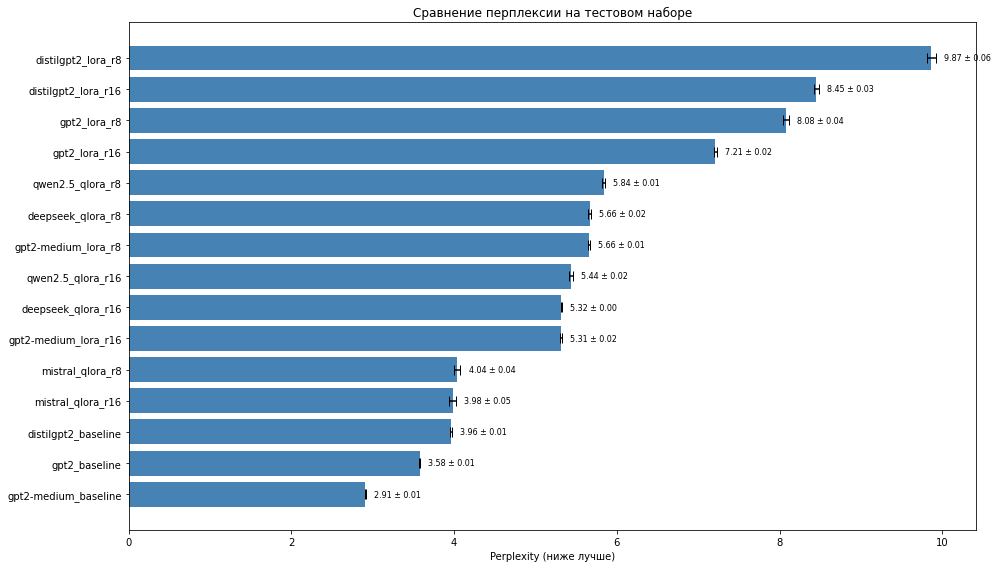

2026-02-24 00:05:03,556 - INFO - 
2026-02-24 00:05:03,557 - INFO - ИТОГОВАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ
2026-02-24 00:05:03,558 - INFO - ============================================================

Модель                              Perplexity           Loss                 Seeds     
gpt2-medium_baseline                2.91 ± 0.01          1.0676 ± 0.0025      3         
gpt2_baseline                       3.58 ± 0.01          1.2743 ± 0.0017      3         
distilgpt2_baseline                 3.96 ± 0.01          1.3772 ± 0.0026      3         
mistral_qlora_r16                   3.98 ± 0.05          1.3815 ± 0.0115      3         
mistral_qlora_r8                    4.04 ± 0.04          1.3965 ± 0.0091      3         
gpt2-medium_lora_r16                5.31 ± 0.02          1.6704 ± 0.0030      3         
deepseek_qlora_r16                  5.32 ± 0.00          1.6707 ± 0.0008      3         
qwen2.5_qlora_r16                   5.44 ± 0.02          1.6929 ± 0.0037      3         
gpt2-med

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
ДОЗАПУСК ОСТАВШИХСЯ ЭКСПЕРИМЕНТОВ (ИСКЛЮЧАЯ DeepSeek R16 seed=44)
Запускает только незавершённые эксперименты, пропуская проблемную модель
"""

import os
import json
import csv
import math
import gc
import time
import sys
import logging
import zipfile
import shutil
import warnings
from datetime import datetime
from pathlib import Path

import torch
import psutil
import matplotlib.pyplot as plt
import numpy as np

from datasets import load_from_disk
from transformers import (
    AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments,
    DataCollatorWithPadding, BitsAndBytesConfig, set_seed
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, TaskType
from huggingface_hub import login

# ======================= КОНФИГУРАЦИЯ =======================
HF_TOKEN = ""
RESULTS_BASE = "./tat_results_final_rf"

# Находим последний запуск
runs = sorted([d for d in Path(RESULTS_BASE).iterdir() if d.is_dir() and d.name.startswith("run_")])
if not runs:
    raise ValueError("Не найдено директорий с результатами")
LATEST_RUN = runs[-1]
print(f"Используем результаты из: {LATEST_RUN}")

# Загружаем конфигурацию экспериментов
with open(LATEST_RUN / "experiments_config.json", "r", encoding="utf-8") as f:
    EXPERIMENTS = json.load(f)

# Загружаем частичные результаты
partial_results_path = LATEST_RUN / "partial_results.json"
if partial_results_path.exists():
    with open(partial_results_path, "r", encoding="utf-8") as f:
        partial_results = json.load(f)
else:
    partial_results = []

# ======================= НАСТРОЙКА ЛОГИРОВАНИЯ =======================
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
log_file = LATEST_RUN / f"resume_{timestamp}.log"

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(log_file, encoding='utf-8'),
        logging.StreamHandler(sys.stdout)
    ]
)
logger = logging.getLogger(__name__)

logger.info(f"Дозапуск экспериментов в: {LATEST_RUN}")
logger.info(f"Лог файл: {log_file}")

# ======================= ПРОВЕРКА УСТРОЙСТВА =======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Устройство: {device}")
if torch.cuda.is_available():
    logger.info(f"GPU: {torch.cuda.get_device_name(0)}")
    logger.info(f"Память GPU: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

if HF_TOKEN:
    try:
        login(token=HF_TOKEN)
        logger.info("Успешный вход в Hugging Face Hub")
    except Exception as e:
        logger.error(f"Ошибка входа: {e}")

# ======================= ФУНКЦИИ ДЛЯ ПРОВЕРКИ И ЗАПУСКА =======================
def experiment_already_done(exp_name, seed_val, results_dir):
    """Проверяет, выполнен ли уже эксперимент с данным seed."""
    marker_file = results_dir / exp_name / f"seed{seed_val}" / "done.txt"
    return marker_file.exists()

def is_excluded_experiment(exp_name, seed_val):
    """Проверяет, является ли эксперимент исключённым (DeepSeek R16 seed=44)."""
    if exp_name == "deepseek_qlora_r16" and seed_val == 44:
        return True
    return False

def get_failed_experiments(experiments, results_dir, num_seeds=3, base_seed=42):
    """Возвращает список экспериментов, которые не были завершены успешно."""
    failed = []
    excluded_count = 0

    for exp in experiments:
        for seed_offset in range(num_seeds):
            seed = base_seed + seed_offset

            if is_excluded_experiment(exp["name"], seed):
                logger.info(f"🚫 Исключаем проблемный: {exp['name']} (seed={seed})")
                excluded_count += 1
                continue

            if not experiment_already_done(exp["name"], seed, results_dir):
                exp_dir = results_dir / exp["name"] / f"seed{seed}"
                oom_marker = exp_dir / "oom.txt"

                if oom_marker.exists():
                    reason = "oom"
                    logger.info(f"⚠️  Предыдущая OOM: {exp['name']} (seed={seed})")
                else:
                    reason = "not_started"
                    logger.info(f"⏳ Не запущен: {exp['name']} (seed={seed})")

                failed.append({
                    "exp": exp,
                    "seed": seed,
                    "reason": reason
                })

    logger.info(f"Исключено проблемных экспериментов: {excluded_count}")
    return failed

# ======================= ОЧИСТКА ПАМЯТИ =======================
def clear_gpu_memory(aggressive=False):
    """Очистка GPU памяти"""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()
        torch.cuda.reset_accumulated_memory_stats()

        if aggressive:
            import ctypes
            try:
                ctypes.CDLL("libc.so.6").malloc_trim(0)
            except:
                pass

        allocated = torch.cuda.memory_allocated() / 1e9
        reserved = torch.cuda.memory_reserved() / 1e9
        logger.info(f"GPU память: {allocated:.2f}GB / {reserved:.2f}GB")
        return allocated, reserved
    return 0, 0

# ======================= ЗАГРУЗКА ТОКЕНИЗИРОВАННЫХ ДАННЫХ =======================
logger.info("\n" + "="*60)
logger.info("ЗАГРУЗКА ТОКЕНИЗИРОВАННЫХ ДАННЫХ")
logger.info("="*60)

tokenized_map = {}
tokenizer_map = {}
groups = ["gpt2", "qwen", "deepseek", "mistral"]

for group in groups:
    tokenized_path = LATEST_RUN / f"tokenized_{group}"
    if tokenized_path.exists():
        logger.info(f"Загрузка токенизированного датасета {group}...")
        tokenized_map[group] = load_from_disk(str(tokenized_path))

        try:
            if group == "gpt2":
                tokenizer_map[group] = AutoTokenizer.from_pretrained("distilgpt2")
            elif group == "qwen":
                tokenizer_map[group] = AutoTokenizer.from_pretrained(
                    "Qwen/Qwen2.5-7B-Instruct",
                    trust_remote_code=True
                )
            elif group == "deepseek":
                tokenizer_map[group] = AutoTokenizer.from_pretrained(
                    "deepseek-ai/deepseek-llm-7b-chat",
                    trust_remote_code=True
                )
            elif group == "mistral":
                tokenizer_map[group] = AutoTokenizer.from_pretrained(
                    "mistralai/Mistral-7B-v0.3",
                    trust_remote_code=True
                )

            if tokenizer_map[group].pad_token is None:
                tokenizer_map[group].pad_token = tokenizer_map[group].eos_token

            logger.info(f"✓ Токенизатор {group} загружен")
        except Exception as e:
            logger.error(f"✗ Ошибка загрузки токенизатора {group}: {e}")
    else:
        logger.warning(f"Токенизированный датасет {group} не найден")

# ======================= ВСПОМОГАТЕЛЬНЫЕ ФУНКЦИИ =======================
def compute_ppl(loss):
    try:
        return math.exp(loss)
    except Exception:
        return None

def get_batch_candidates(initial_bs):
    candidates = []
    bs = initial_bs
    while True:
        candidates.append(max(1, int(bs)))
        if bs == 1:
            break
        bs = bs // 2
    return candidates

class DataCollatorForCausalLMWithLabelPad:
    def __init__(self, tokenizer, label_pad_token_id: int = -100, pad_to_multiple_of: int = None):
        self.tokenizer = tokenizer
        self.label_pad_token_id = label_pad_token_id
        self.base_collator = DataCollatorWithPadding(
            tokenizer,
            padding=True,
            return_tensors="pt",
            pad_to_multiple_of=pad_to_multiple_of
        )

    def __call__(self, features):
        allowed_keys = ["input_ids", "attention_mask", "labels"]
        filtered_features = [{k: f[k] for k in allowed_keys if k in f} for f in features]
        labels = [f.pop("labels") if "labels" in f else None for f in filtered_features]
        batch = self.base_collator(filtered_features)
        if any(l is not None for l in labels):
            max_len = batch["input_ids"].shape[1]
            padded_labels = []
            for l in labels:
                if l is None:
                    padded = [self.label_pad_token_id] * max_len
                else:
                    l = list(l)
                    if len(l) < max_len:
                        padded = l + [self.label_pad_token_id] * (max_len - len(l))
                    else:
                        padded = l[:max_len]
                padded_labels.append(padded)
            batch["labels"] = torch.tensor(padded_labels, dtype=torch.long)
        return batch

# ======================= ОСНОВНАЯ ФУНКЦИЯ ЗАПУСКА =======================
def run_experiment(exp_cfg, tokenized_data, tokenizer, results_dir, seed_val):
    name = exp_cfg["name"]
    model_name = exp_cfg["model_name"]
    use_lora = exp_cfg.get("use_lora", False)
    use_qlora = exp_cfg.get("use_qlora", False)
    use_fp16 = exp_cfg.get("fp16", True)
    initial_bs = exp_cfg.get("batch_size", 8)
    epochs = exp_cfg.get("epochs", 1)

    # !!! ВАЖНО: Отключаем упрощение архитектуры для Mistral !!!
    simplify_architecture = False  # Было: "mistral" in model_name.lower() and "7b" in model_name.lower()

    # Проверка на уже выполненный
    if experiment_already_done(name, seed_val, results_dir):
        logger.info(f"Эксперимент {name} (seed={seed_val}) уже выполнен, пропускаем.")
        return {"skipped": True, "name": name, "seed": seed_val}

    def _fmt(val, fmt="{:.4f}"):
        try:
            return fmt.format(val) if val is not None else "None"
        except Exception:
            try:
                return str(val)
            except Exception:
                return "None"

    batch_candidates = get_batch_candidates(initial_bs)
    result = {
        "name": name,
        "model_name": model_name,
        "seed": seed_val,
        "attempts": [],
        "config": exp_cfg.copy()
    }
    start_total = time.time()

    seed_dir = results_dir / name / f"seed{seed_val}"
    seed_dir.mkdir(parents=True, exist_ok=True)
    with open(seed_dir / "in_progress.txt", "w") as f:
        f.write(f"started at {datetime.now()}")

    for bs in batch_candidates:
        logger.info(f"--- Попытка {name} (seed={seed_val}) с batch_size={bs} ---")
        attempt_start = time.time()

        if torch.cuda.is_available():
            try:
                torch.cuda.reset_peak_memory_stats()
            except Exception:
                pass

        model = None
        trainer = None

        try:
            load_kwargs = {
                "low_cpu_mem_usage": True,
                "trust_remote_code": True,
                "token": HF_TOKEN
            }

            # Настройка квантизации для QLoRA
            if use_qlora:
                bnb_config = BitsAndBytesConfig(
                    load_in_4bit=True,
                    bnb_4bit_use_double_quant=True,
                    bnb_4bit_quant_type="nf4",
                    bnb_4bit_compute_dtype=torch.float16
                )
                load_kwargs["quantization_config"] = bnb_config
                load_kwargs["device_map"] = "auto"
            else:
                if use_fp16 and torch.cuda.is_available():
                    load_kwargs["torch_dtype"] = torch.float16
                else:
                    load_kwargs["torch_dtype"] = torch.float32

            logger.info(f"Загрузка модели: {model_name}")

            try:
                model = AutoModelForCausalLM.from_pretrained(model_name, **load_kwargs)
            except Exception as e:
                logger.error(f"Не удалось загрузить модель {model_name}: {e}")
                result["attempts"].append({
                    "batch_size": bs,
                    "status": "load_error",
                    "error": str(e)[:200]
                })
                if "out of memory" in str(e).lower():
                    with open(seed_dir / "oom.txt", "w") as f:
                        f.write(f"OOM at {datetime.now()}\n{str(e)}")
                break

            # LoRA настройка
            trainable_params = None
            if use_lora:
                if use_qlora:
                    model = prepare_model_for_kbit_training(model)

                target_modules = exp_cfg.get("target_modules")
                if target_modules is None:
                    target_modules = ["c_attn"] if "gpt2" in model_name.lower() else ["q_proj", "v_proj"]

                lora_config = LoraConfig(
                    r=exp_cfg["lora_r"],
                    lora_alpha=exp_cfg["lora_alpha"],
                    target_modules=target_modules,
                    lora_dropout=exp_cfg.get("lora_dropout", 0.0),
                    bias="none",
                    task_type=TaskType.CAUSAL_LM
                )
                model = get_peft_model(model, lora_config)
                try:
                    trainable_params = model.num_parameters(only_trainable=True)
                    logger.info(f"📊 Trainable params: {trainable_params:,}")
                except Exception:
                    trainable_params = None
            else:
                if not hasattr(model, "hf_device_map"):
                    model = model.to(device)
                try:
                    model.gradient_checkpointing_enable()
                except Exception:
                    pass

            output_dir = seed_dir / f"bs{bs}"
            output_dir.mkdir(parents=True, exist_ok=True)

            optim = "adamw_8bit" if use_qlora else "adamw_torch"

            training_args = TrainingArguments(
                output_dir=str(output_dir),
                per_device_train_batch_size=bs,
                per_device_eval_batch_size=bs,
                gradient_accumulation_steps=2,
                learning_rate=2e-4,
                num_train_epochs=epochs,
                logging_steps=50,
                eval_strategy="steps",
                eval_steps=50,
                save_strategy="no",
                report_to="none",
                fp16=(use_fp16 and torch.cuda.is_available()),
                gradient_checkpointing=True,
                optim=optim,
                seed=seed_val,
                remove_unused_columns=True,
                dataloader_num_workers=0,
                ddp_find_unused_parameters=False if use_lora else None,
            )

            data_collator = DataCollatorForCausalLMWithLabelPad(
                tokenizer=tokenizer,
                label_pad_token_id=-100,
                pad_to_multiple_of=8
            )

            trainer = Trainer(
                model=model,
                args=training_args,
                train_dataset=tokenized_data["train"],
                eval_dataset=tokenized_data["eval"],
                data_collator=data_collator,
            )

            try:
                trainer.train()
            except RuntimeError as e:
                msg = str(e).lower()
                if "out of memory" in msg or ("cuda" in msg and "memory" in msg):
                    logger.warning(f"OOM при batch_size={bs}")
                    result["attempts"].append({
                        "batch_size": bs,
                        "status": "oom",
                        "error": str(e)[:200]
                    })
                    with open(seed_dir / "oom.txt", "w") as f:
                        f.write(f"OOM at {datetime.now()}\n{str(e)}")
                    try:
                        del trainer
                    except:
                        pass
                    try:
                        del model
                    except:
                        pass
                    clear_gpu_memory(aggressive=True)
                    continue
                else:
                    raise

            if use_lora:
                adapter_save_path = output_dir / "adapter"
                model.save_pretrained(adapter_save_path)
                logger.info(f"Адаптер сохранён в {adapter_save_path}")

            try:
                with open(output_dir / "log_history.json", "w", encoding="utf-8") as f:
                    json.dump(getattr(trainer.state, "log_history", []), f, indent=2, ensure_ascii=False)
            except Exception as e_log:
                logger.warning(f"Не удалось сохранить log_history: {e_log}")

            eval_metrics = {}
            try:
                eval_metrics = trainer.evaluate(eval_dataset=tokenized_data["test"])
            except Exception as e_eval:
                logger.warning(f"Ошибка при evaluate: {e_eval}")

            test_loss = eval_metrics.get("eval_loss") if isinstance(eval_metrics, dict) else None
            test_ppl = compute_ppl(test_loss) if test_loss is not None else None

            peak_gpu_mem = None
            if torch.cuda.is_available():
                try:
                    peak_gpu_mem = torch.cuda.max_memory_allocated() / 1e9
                except Exception:
                    peak_gpu_mem = None

            elapsed = time.time() - attempt_start

            loss_str = _fmt(test_loss, "{:.4f}")
            ppl_str = _fmt(test_ppl, "{:.2f}")
            gpu_str = _fmt(peak_gpu_mem, "{:.2f}")

            logger.info(f"✅ Успех! Loss={loss_str}, PPL={ppl_str}, время={elapsed:.1f}с, пик GPU={gpu_str}GB")

            result.update({
                "status": "success",
                "batch_size": bs,
                "test_loss": test_loss,
                "test_perplexity": test_ppl,
                "trainable_params": trainable_params,
                "peak_gpu_memory_gb": peak_gpu_mem,
                "time_seconds": elapsed,
                "total_time_seconds": time.time() - start_total
            })
            result["attempts"].append({
                "batch_size": bs,
                "status": "success",
                "eval_loss": test_loss,
                "perplexity": test_ppl,
                "time_seconds": elapsed
            })

            if (seed_dir / "in_progress.txt").exists():
                (seed_dir / "in_progress.txt").unlink()
            with open(seed_dir / "done.txt", "w") as f:
                f.write(f"success with batch_size={bs} at {datetime.now()}")

            try:
                del trainer
            except:
                pass
            try:
                del model
            except:
                pass
            clear_gpu_memory()
            return result

        except Exception as e:
            logger.error(f"Ошибка при batch_size={bs}: {e}")
            result["attempts"].append({"batch_size": bs, "status": "error", "error": str(e)[:200]})
            try:
                del model
            except:
                pass
            try:
                del trainer
            except:
                pass
            clear_gpu_memory(aggressive=True)
            continue

    result["status"] = "failed_all_bs"
    result["total_time_seconds"] = time.time() - start_total

    if (seed_dir / "in_progress.txt").exists():
        (seed_dir / "in_progress.txt").unlink()

    return result

# ======================= ПОИСК НЕЗАВЕРШЁННЫХ ЭКСПЕРИМЕНТОВ =======================
logger.info("\n" + "="*60)
logger.info("ПОИСК НЕЗАВЕРШЁННЫХ ЭКСПЕРИМЕНТОВ")
logger.info("="*60)

failed_experiments = get_failed_experiments(EXPERIMENTS, LATEST_RUN, num_seeds=3, base_seed=42)
logger.info(f"Найдено {len(failed_experiments)} незавершённых экспериментов")

if not failed_experiments:
    logger.info("🎉 Все эксперименты уже завершены!")
else:
    logger.info("\n📋 Список для дозапуска:")
    for i, fe in enumerate(failed_experiments, 1):
        status_symbol = "⚠️" if fe['reason'] == 'oom' else "⏳"
        logger.info(f"{i}. {status_symbol} {fe['exp']['name']} (seed={fe['seed']}) - {fe['reason']}")

# ======================= ОПТИМИЗАЦИЯ ДЛЯ 7B МОДЕЛЕЙ =======================
logger.info("\n" + "="*60)
logger.info("ОПТИМИЗАЦИЯ НАСТРОЕК ДЛЯ 7B МОДЕЛЕЙ")
logger.info("="*60)

for fe in failed_experiments:
    exp = fe['exp']
    if "7b" in exp['model_name'].lower() or "7B" in exp['model_name']:
        exp['batch_size'] = 1
        exp['use_qlora'] = True
        exp['fp16'] = True
        exp['gradient_checkpointing'] = True
        logger.info(f"✓ Оптимизирован {exp['name']}: batch_size=1, QLoRA=True")

# ======================= ЗАПУСК ЭКСПЕРИМЕНТОВ =======================
if failed_experiments:
    logger.info("\n" + "="*60)
    logger.info("ЗАПУСК НЕЗАВЕРШЁННЫХ ЭКСПЕРИМЕНТОВ")
    logger.info("="*60)

    resumed_results = []
    total = len(failed_experiments)

    for i, fe in enumerate(failed_experiments, 1):
        exp = fe['exp']
        seed = fe['seed']
        group = exp['tokenizer_group']

        logger.info(f"\n[{i}/{total}] {'='*50}")
        logger.info(f"Запуск: {exp['name']} (seed={seed})")
        logger.info(f"{'='*50}")

        tokenized_data = tokenized_map.get(group)
        tokenizer = tokenizer_map.get(group)

        if tokenized_data is None or tokenizer is None:
            logger.error(f"❌ Нет токенизированных данных для группы {group}, пропускаем")
            continue

        logger.info("Очистка памяти перед запуском...")
        clear_gpu_memory(aggressive=True)

        set_seed(seed)

        try:
            res = run_experiment(exp, tokenized_data, tokenizer, LATEST_RUN, seed)

            if not res.get("skipped", False):
                resumed_results.append(res)
                logger.info(f"✅ Завершён: {exp['name']} (seed={seed})")
            else:
                logger.info(f"⏭️ Пропущен: {exp['name']} (seed={seed})")

        except KeyboardInterrupt:
            logger.info("⏸️ Дозапуск прерван пользователем")
            break
        except Exception as e:
            logger.error(f"❌ Критическая ошибка при запуске {exp['name']} (seed={seed}): {e}")
            import traceback
            traceback.print_exc()

        all_results = partial_results + resumed_results
        with open(LATEST_RUN / "partial_results.json", "w", encoding="utf-8") as f:
            json.dump(all_results, f, indent=2, ensure_ascii=False)

        with open(LATEST_RUN / "resumed_results.json", "w", encoding="utf-8") as f:
            json.dump(resumed_results, f, indent=2, ensure_ascii=False)

        logger.info(f"📊 Прогресс: {i}/{total} ({i/total*100:.1f}%)")

        clear_gpu_memory(aggressive=True)
        time.sleep(5)

    logger.info("\n" + "="*60)
    logger.info("ДОЗАПУСК ЗАВЕРШЁН")
    logger.info(f"Дополнительно выполнено: {len(resumed_results)} экспериментов")
    logger.info("="*60)

# ======================= ОБНОВЛЕНИЕ АГРЕГИРОВАННЫХ РЕЗУЛЬТАТОВ =======================
logger.info("\n" + "="*60)
logger.info("ОБНОВЛЕНИЕ АГРЕГИРОВАННЫХ РЕЗУЛЬТАТОВ")
logger.info("="*60)

with open(LATEST_RUN / "partial_results.json", "r", encoding="utf-8") as f:
    all_results = json.load(f)

grouped = {}
for r in all_results:
    if r.get("status") == "success":
        name = r["name"]
        if name not in grouped:
            grouped[name] = []
        grouped[name].append(r)

aggregated = []
for name, runs in grouped.items():
    ppls = [r["test_perplexity"] for r in runs if r["test_perplexity"] is not None]
    losses = [r["test_loss"] for r in runs if r["test_loss"] is not None]
    if not ppls:
        continue

    agg = {
        "name": name,
        "model_name": runs[0]["model_name"],
        "num_seeds": len(runs),
        "test_perplexity_mean": float(np.mean(ppls)),
        "test_perplexity_std": float(np.std(ppls)),
        "test_loss_mean": float(np.mean(losses)),
        "test_loss_std": float(np.std(losses)),
        "peak_gpu_memory_gb_mean": float(np.mean([r["peak_gpu_memory_gb"] for r in runs if r["peak_gpu_memory_gb"]])),
        "time_seconds_mean": float(np.mean([r["time_seconds"] for r in runs])),
        "trainable_params": runs[0].get("trainable_params"),
        "all_seeds": runs
    }
    aggregated.append(agg)

with open(LATEST_RUN / "aggregated_results.json", "w", encoding="utf-8") as f:
    json.dump(aggregated, f, indent=2, ensure_ascii=False)

csv_agg_file = LATEST_RUN / "aggregated_results.csv"
fieldnames_agg = ["name", "model_name", "num_seeds", "test_perplexity_mean", "test_perplexity_std",
                  "test_loss_mean", "test_loss_std", "peak_gpu_memory_gb_mean", "time_seconds_mean", "trainable_params"]

with open(csv_agg_file, "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames_agg)
    writer.writeheader()
    for a in aggregated:
        writer.writerow({
            "name": a["name"],
            "model_name": a["model_name"],
            "num_seeds": a["num_seeds"],
            "test_perplexity_mean": f"{a['test_perplexity_mean']:.4f}",
            "test_perplexity_std": f"{a['test_perplexity_std']:.4f}",
            "test_loss_mean": f"{a['test_loss_mean']:.4f}",
            "test_loss_std": f"{a['test_loss_std']:.4f}",
            "peak_gpu_memory_gb_mean": f"{a['peak_gpu_memory_gb_mean']:.2f}",
            "time_seconds_mean": f"{a['time_seconds_mean']:.1f}",
            "trainable_params": a["trainable_params"]
        })

logger.info(f"Агрегированные результаты сохранены в {csv_agg_file}")

# ======================= ВИЗУАЛИЗАЦИЯ =======================
if aggregated:
    aggregated.sort(key=lambda x: x["test_perplexity_mean"])
    names = [a["name"] for a in aggregated]
    ppl_means = [a["test_perplexity_mean"] for a in aggregated]
    ppl_stds = [a["test_perplexity_std"] for a in aggregated]

    plt.figure(figsize=(14, 8))
    y_pos = np.arange(len(names))
    plt.barh(y_pos, ppl_means, xerr=ppl_stds, capsize=5, color='steelblue')
    plt.yticks(y_pos, names)
    plt.xlabel("Perplexity (ниже лучше)")
    plt.title("Сравнение перплексии на тестовом наборе")

    for i, (mean, std) in enumerate(zip(ppl_means, ppl_stds)):
        plt.text(mean + std + 0.1, i, f'{mean:.2f} ± {std:.2f}', va='center', fontsize=8)

    plt.tight_layout()
    plt.savefig(LATEST_RUN / "perplexity_comparison_updated.png", dpi=150)
    plt.show()

# ======================= ФИНАЛЬНЫЙ ОТЧЁТ =======================
logger.info("\n" + "="*60)
logger.info("ИТОГОВАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ")
logger.info("="*60)

print("\n" + "="*80)
print(f"{'Модель':<35} {'Perplexity':<20} {'Loss':<20} {'Seeds':<10}")
print("="*80)

for a in sorted(aggregated, key=lambda x: x["test_perplexity_mean"]):
    name = a['name'][:35]
    ppl = f"{a['test_perplexity_mean']:.2f} ± {a['test_perplexity_std']:.2f}"
    loss = f"{a['test_loss_mean']:.4f} ± {a['test_loss_std']:.4f}"
    seeds = str(a['num_seeds'])
    print(f"{name:<35} {ppl:<20} {loss:<20} {seeds:<10}")

print("="*80)

# Проверяем завершение
all_completed = True
excluded_found = False

for exp in EXPERIMENTS:
    for seed_offset in range(3):
        seed = 42 + seed_offset

        if is_excluded_experiment(exp["name"], seed):
            excluded_found = True
            continue

        if not experiment_already_done(exp["name"], seed, LATEST_RUN):
            all_completed = False
            logger.warning(f"⚠️  Не завершён: {exp['name']} (seed={seed})")

if all_completed:
    logger.info("🎉 ПОЗДРАВЛЯЮ! ВСЕ ЭКСПЕРИМЕНТЫ УСПЕШНО ЗАВЕРШЕНЫ!")
    if excluded_found:
        logger.info("🚫 Исключён: deepseek_qlora_r16 (seed=44)")
else:
    logger.info("⏳ Некоторые эксперименты ещё не завершены.")

logger.info(f"\nВсе результаты сохранены в: {LATEST_RUN}")
logger.info(f"Лог файл: {log_file}")

In [ ]:
print(8)

8


In [ ]:
import zipfile
import os
from pathlib import Path
from IPython.display import FileLink, display

# Создаем архив с полными результатами
results_path = Path("./tat_results_final_rf/run_20260223_070746")
zip_name = "tat_results_complete.zip"

with zipfile.ZipFile(zip_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(results_path):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, results_path)
            zipf.write(file_path, arcname)

print(f"Архив создан: {zip_name}")
print(f"Размер: {os.path.getsize(zip_name)/1024/1024:.2f} MB")
display(FileLink(zip_name))

Архив создан: tat_results_complete.zip
Размер: 1118.42 MB


/home/kfu/tat_results_complete.zip

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
test_trained_models.py

Скрипт для тестирования обученных моделей из эксперимента.
Поддерживает:
- Загрузку сохраненных моделей (полных и LoRA адаптеров)
- Вычисление perplexity на тестовом наборе
- Интерактивную генерацию текста
- Пакетное сравнение моделей на заданных промптах
"""

import os
import json
import math
import gc
import sys
import torch
from pathlib import Path
from typing import List, Dict, Optional, Tuple
import warnings
warnings.filterwarnings("ignore")

from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    pipeline
)
from peft import PeftModel, PeftConfig
from datasets import load_from_disk

# ======================= КОНФИГУРАЦИЯ =======================
# Путь к результатам эксперимента (укажите ваш последний запуск)
RESULTS_PATH = Path("./tat_results_final_rf/run_20260223_070746")

# Максимальная длина для генерации
MAX_NEW_TOKENS = 100
TEMPERATURE = 0.7
TOP_P = 0.9
TOP_K = 50

# ======================= ЗАГРУЗКА ДАННЫХ =======================
def load_test_dataset(results_path: Path, group: str):
    """Загружает тестовую выборку для указанной группы токенизатора."""
    tokenized_path = results_path / f"tokenized_{group}"
    if not tokenized_path.exists():
        print(f"❌ Токенизированный датасет для {group} не найден: {tokenized_path}")
        return None

    try:
        dataset = load_from_disk(str(tokenized_path))
        if "test" in dataset:
            print(f"✓ Загружен тестовый набор для {group}: {len(dataset['test'])} примеров")
            return dataset["test"]
        else:
            print(f"⚠️ В датасете {group} нет тестовой выборки")
            return None
    except Exception as e:
        print(f"❌ Ошибка загрузки датасета {group}: {e}")
        return None

# ======================= ЗАГРУЗКА МОДЕЛИ =======================
def load_model(
    experiment_path: Path,
    seed: int,
    batch_size: int,
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
):
    """
    Загружает сохраненную модель.

    Args:
        experiment_path: Путь к эксперименту (например, tat_results/.../mistral_qlora_r16)
        seed: Сид (42, 43, 44)
        batch_size: Размер батча, с которым модель была сохранена (bs1, bs2, ...)

    Returns:
        (model, tokenizer, config)
    """
    seed_path = experiment_path / f"seed{seed}" / f"bs{batch_size}"

    if not seed_path.exists():
        print(f"❌ Путь не найден: {seed_path}")
        return None, None, None

    # Загружаем конфигурацию эксперимента
    config_path = RESULTS_PATH / "experiments_config.json"
    exp_name = experiment_path.name

    if config_path.exists():
        with open(config_path, "r") as f:
            all_configs = json.load(f)
        exp_config = next((c for c in all_configs if c["name"] == exp_name), None)
    else:
        exp_config = None

    if exp_config is None:
        print(f"⚠️ Конфигурация для {exp_name} не найдена, используем стандартные параметры")
        base_model_name = "mistralai/Mistral-7B-v0.3"  # По умолчанию
        use_qlora = True
        use_lora = True
    else:
        base_model_name = exp_config["model_name"]
        use_qlora = exp_config.get("use_qlora", False)
        use_lora = exp_config.get("use_lora", False)

    print(f"\n🔧 Загрузка модели: {exp_name}")
    print(f"   Базовая модель: {base_model_name}")
    print(f"   Путь к адаптеру: {seed_path}")

    # Загружаем токенизатор
    try:
        tokenizer = AutoTokenizer.from_pretrained(base_model_name, trust_remote_code=True)
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
        print("✓ Токенизатор загружен")
    except Exception as e:
        print(f"❌ Ошибка загрузки токенизатора: {e}")
        return None, None, None

    # Настройки загрузки базовой модели
    load_kwargs = {
        "low_cpu_mem_usage": True,
        "trust_remote_code": True,
        "device_map": "auto" if use_qlora else device,
    }

    if use_qlora:
        # Для QLoRA моделей загружаем с той же квантизацией
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float16
        )
        load_kwargs["quantization_config"] = bnb_config
        load_kwargs["torch_dtype"] = torch.float16
    else:
        load_kwargs["torch_dtype"] = torch.float16 if torch.cuda.is_available() else torch.float32

    # Загружаем базовую модель
    try:
        print("⏳ Загрузка базовой модели...")
        base_model = AutoModelForCausalLM.from_pretrained(base_model_name, **load_kwargs)
        print("✓ Базовая модель загружена")
    except Exception as e:
        print(f"❌ Ошибка загрузки базовой модели: {e}")
        return None, None, None

    # Загружаем LoRA адаптер, если он есть
    adapter_path = seed_path / "adapter"
    if adapter_path.exists() and use_lora:
        try:
            print(f"⏳ Загрузка LoRA адаптера из {adapter_path}...")
            model = PeftModel.from_pretrained(base_model, adapter_path)
            print("✓ LoRA адаптер загружен")
        except Exception as e:
            print(f"❌ Ошибка загрузки LoRA адаптера: {e}")
            model = base_model
    else:
        print("⚠️ LoRA адаптер не найден, использую базовую модель")
        model = base_model

    model.eval()
    return model, tokenizer, exp_config

# ======================= ВЫЧИСЛЕНИЕ PERPLEXITY =======================
@torch.no_grad()
def compute_perplexity(model, tokenizer, test_dataset, max_samples=100):
    """
    Вычисляет среднюю perplexity на тестовой выборке.

    Args:
        model: Загруженная модель
        tokenizer: Токенизатор
        test_dataset: Тестовый датасет (токенизированный)
        max_samples: Максимальное количество примеров для оценки

    Returns:
        Средняя perplexity
    """
    if test_dataset is None:
        return None

    device = next(model.parameters()).device
    model.eval()

    losses = []
    n_samples = min(len(test_dataset), max_samples)

    print(f"\n📊 Вычисление perplexity на {n_samples} примерах...")

    for i in range(n_samples):
        if i % 20 == 0:
            print(f"   Прогресс: {i}/{n_samples}")

        # Берем пример из датасета
        item = test_dataset[i]
        input_ids = torch.tensor(item["input_ids"]).unsqueeze(0).to(device)
        attention_mask = torch.tensor(item["attention_mask"]).unsqueeze(0).to(device)

        # Вычисляем loss
        try:
            outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
            loss = outputs.loss.item()
            losses.append(loss)
        except Exception as e:
            print(f"   ⚠️ Ошибка на примере {i}: {e}")
            continue

    if not losses:
        return None

    avg_loss = sum(losses) / len(losses)
    try:
        ppl = math.exp(avg_loss)
    except OverflowError:
        ppl = float('inf')

    print(f"\n✅ Результаты на {len(losses)} примерах:")
    print(f"   Средний loss: {avg_loss:.4f}")
    print(f"   Perplexity: {ppl:.2f}")

    return ppl

# ======================= ГЕНЕРАЦИЯ ТЕКСТА =======================
def generate_text(model, tokenizer, prompt: str, max_new_tokens=100,
                  temperature=0.7, top_p=0.9, top_k=50, num_return_sequences=1):
    """
    Генерирует текст на основе промпта.
    """
    device = next(model.parameters()).device

    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            top_p=top_p,
            top_k=top_k,
            do_sample=True,
            num_return_sequences=num_return_sequences,
            pad_token_id=tokenizer.eos_token_id,
            repetition_penalty=1.1
        )

    generated_texts = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    return generated_texts

# ======================= ИНТЕРАКТИВНЫЙ РЕЖИМ =======================
def interactive_mode(model, tokenizer, model_name):
    """Интерактивный режим для одной модели."""
    print(f"\n{'='*60}")
    print(f"🤖 Интерактивный режим для {model_name}")
    print(f"{'='*60}")
    print("Команды:")
    print("  /quit - выход")
    print("  /temp <value> - изменить температуру (0.1-2.0)")
    print("  /clear - очистить экран")
    print(f"{'='*60}\n")

    temperature = TEMPERATURE

    while True:
        try:
            prompt = input("\n📝 Введите промпт (или команду): ").strip()

            if prompt.lower() == "/quit":
                break
            elif prompt.lower().startswith("/temp"):
                try:
                    new_temp = float(prompt.split()[1])
                    temperature = max(0.1, min(2.0, new_temp))
                    print(f"✓ Температура изменена на {temperature}")
                except:
                    print("⚠️ Используйте: /temp <значение>")
                continue
            elif prompt.lower() == "/clear":
                os.system('clear' if os.name == 'posix' else 'cls')
                continue
            elif not prompt:
                continue

            print("\n⏳ Генерация...")
            generated = generate_text(
                model, tokenizer, prompt,
                max_new_tokens=MAX_NEW_TOKENS,
                temperature=temperature,
                top_p=TOP_P,
                top_k=TOP_K
            )

            print("\n" + "-"*40)
            print("✨ Результат:")
            print(generated[0])
            print("-"*40)

        except KeyboardInterrupt:
            print("\n\n⏸️ Прервано пользователем")
            break
        except Exception as e:
            print(f"❌ Ошибка: {e}")

# ======================= СРАВНЕНИЕ МОДЕЛЕЙ =======================
def compare_models(models_dict: Dict[str, Tuple], prompts: List[str]):
    """
    Сравнивает несколько моделей на одних и тех же промптах.

    Args:
        models_dict: {имя_модели: (model, tokenizer)}
        prompts: Список промптов для тестирования
    """
    print(f"\n{'='*70}")
    print("🔬 СРАВНЕНИЕ МОДЕЛЕЙ")
    print(f"{'='*70}")

    results = {}

    for prompt in prompts:
        print(f"\n📌 Промпт: '{prompt}'")
        print("-" * 50)

        for model_name, (model, tokenizer) in models_dict.items():
            try:
                generated = generate_text(
                    model, tokenizer, prompt,
                    max_new_tokens=50,
                    temperature=0.8,
                    top_p=0.9
                )
                print(f"\n[{model_name}]:")
                print(f"  {generated[0]}")
                results.setdefault(model_name, []).append(generated[0])
            except Exception as e:
                print(f"\n[{model_name}]: ❌ Ошибка - {e}")

        print("-" * 50)

    return results

# ======================= ОСНОВНАЯ ФУНКЦИЯ =======================
def main():
    print("="*70)
    print("🧪 ТЕСТИРОВАНИЕ ОБУЧЕННЫХ МОДЕЛЕЙ")
    print(f"Результаты из: {RESULTS_PATH}")
    print("="*70)

    # Проверяем наличие результатов
    if not RESULTS_PATH.exists():
        print(f"❌ Путь не найден: {RESULTS_PATH}")
        return

    # Получаем список всех экспериментов
    experiments = [d for d in RESULTS_PATH.iterdir()
                   if d.is_dir() and not d.name.startswith(('tokenized_', 'raw_subset'))]

    print(f"\n📋 Найденные эксперименты:")
    for i, exp in enumerate(experiments, 1):
        print(f"  {i}. {exp.name}")

    # Выбор режима
    print("\n🎮 Выберите режим:")
    print("  1. Интерактивный режим для одной модели")
    print("  2. Сравнить несколько моделей")
    print("  3. Вычислить perplexity для всех моделей")
    print("  0. Выход")

    choice = input("\nВаш выбор (0-3): ").strip()

    if choice == "0":
        return

    elif choice == "1":
        # Интерактивный режим
        exp_idx = int(input(f"Выберите эксперимент (1-{len(experiments)}): ")) - 1
        exp_path = experiments[exp_idx]

        seed = int(input("Сид (42, 43, 44): "))
        batch_size = int(input("Batch size (обычно 1 или 4): "))

        model, tokenizer, config = load_model(exp_path, seed, batch_size)

        if model is not None:
            group = config.get("tokenizer_group", "unknown") if config else "unknown"
            test_dataset = load_test_dataset(RESULTS_PATH, group)

            if test_dataset is not None:
                compute_perplexity(model, tokenizer, test_dataset, max_samples=50)

            interactive_mode(model, tokenizer, f"{exp_path.name} (seed={seed})")

    elif choice == "2":
        # Сравнение моделей
        models_to_compare = {}

        print("\nВыберите модели для сравнения (введите индексы через пробел):")
        for i, exp in enumerate(experiments, 1):
            print(f"  {i}. {exp.name}")

        indices = input("Индексы: ").strip().split()

        for idx_str in indices:
            try:
                idx = int(idx_str) - 1
                exp_path = experiments[idx]

                seed = int(input(f"Сид для {exp_path.name} (42, 43, 44): "))
                batch_size = int(input(f"Batch size для {exp_path.name} (обычно 1 или 4): "))

                model, tokenizer, config = load_model(exp_path, seed, batch_size)

                if model is not None:
                    models_to_compare[f"{exp_path.name}_s{seed}"] = (model, tokenizer)
            except Exception as e:
                print(f"❌ Ошибка загрузки модели {idx_str}: {e}")

        if models_to_compare:
            # Промпты для сравнения
            test_prompts = [
                "Минем исемем",
                "Бүгенге көндә",
                "Татарстан -",
                "Мәктәптә без",
                "Кыш көне"
            ]

            compare_models(models_to_compare, test_prompts)

    elif choice == "3":
        # Пакетное вычисление perplexity
        print("\n📊 Пакетное вычисление perplexity")

        results = []
        for exp_path in experiments:
            for seed in [42, 43, 44]:
                # Пробуем разные batch_size
                for bs in [1, 4, 8]:
                    model, tokenizer, config = load_model(exp_path, seed, bs)
                    if model is not None:
                        group = config.get("tokenizer_group", "unknown") if config else "unknown"
                        test_dataset = load_test_dataset(RESULTS_PATH, group)

                        if test_dataset is not None:
                            ppl = compute_perplexity(model, tokenizer, test_dataset, max_samples=100)
                            results.append({
                                "experiment": exp_path.name,
                                "seed": seed,
                                "batch_size": bs,
                                "perplexity": ppl
                            })
                        break  # Нашли рабочую конфигурацию, выходим из цикла по bs
                    else:
                        continue
                    break

        # Сохраняем результаты
        if results:
            output_file = RESULTS_PATH / "test_results.json"
            with open(output_file, "w", encoding="utf-8") as f:
                json.dump(results, f, indent=2, ensure_ascii=False)
            print(f"\n✅ Результаты сохранены в {output_file}")

    print("\n👋 До свидания!")

if __name__ == "__main__":
    main()

🧪 ТЕСТИРОВАНИЕ ОБУЧЕННЫХ МОДЕЛЕЙ
Результаты из: tat_results_final_rf/run_20260223_070746

📋 Найденные эксперименты:
  1. gpt2_lora_r8
  2. distilgpt2_lora_r16
  3. gpt2-medium_baseline
  4. mistral_qlora_r8
  5. distilgpt2_baseline
  6. qwen2.5_qlora_r8
  7. gpt2-medium_lora_r16
  8. deepseek_qlora_r8
  9. mistral_qlora_r16
  10. qwen2.5_qlora_r16
  11. gpt2-medium_lora_r8
  12. gpt2_baseline
  13. gpt2_lora_r16
  14. distilgpt2_lora_r8
  15. deepseek_qlora_r16

🎮 Выберите режим:
  1. Интерактивный режим для одной модели
  2. Сравнить несколько моделей
  3. Вычислить perplexity для всех моделей
  0. Выход

Ваш выбор (0-3): 2

Выберите модели для сравнения (введите индексы через пробел):
  1. gpt2_lora_r8
  2. distilgpt2_lora_r16
  3. gpt2-medium_baseline
  4. mistral_qlora_r8
  5. distilgpt2_baseline
  6. qwen2.5_qlora_r8
  7. gpt2-medium_lora_r16
  8. deepseek_qlora_r8
  9. mistral_qlora_r16
  10. qwen2.5_qlora_r16
  11. gpt2-medium_lora_r8
  12. gpt2_baseline
  13. gpt2_lora_r16
  14

Loading weights:   0%|          | 0/292 [00:00<?, ?it/s]

✓ Базовая модель загружена
⚠️ LoRA адаптер не найден, использую базовую модель
Сид для mistral_qlora_r8 (42, 43, 44): 42
Batch size для mistral_qlora_r8 (обычно 1 или 4): 1

🔧 Загрузка модели: mistral_qlora_r8
   Базовая модель: mistralai/Mistral-7B-v0.3
   Путь к адаптеру: tat_results_final_rf/run_20260223_070746/mistral_qlora_r8/seed42/bs1
✓ Токенизатор загружен
⏳ Загрузка базовой модели...


Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

✓ Базовая модель загружена
⏳ Загрузка LoRA адаптера из tat_results_final_rf/run_20260223_070746/mistral_qlora_r8/seed42/bs1/adapter...
✓ LoRA адаптер загружен
Сид для mistral_qlora_r16 (42, 43, 44): 42
Batch size для mistral_qlora_r16 (обычно 1 или 4): 1

🔧 Загрузка модели: mistral_qlora_r16
   Базовая модель: mistralai/Mistral-7B-v0.3
   Путь к адаптеру: tat_results_final_rf/run_20260223_070746/mistral_qlora_r16/seed42/bs1
✓ Токенизатор загружен
⏳ Загрузка базовой модели...


Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

✓ Базовая модель загружена
⏳ Загрузка LoRA адаптера из tat_results_final_rf/run_20260223_070746/mistral_qlora_r16/seed42/bs1/adapter...
✓ LoRA адаптер загружен
Сид для gpt2_baseline (42, 43, 44): 42
Batch size для gpt2_baseline (обычно 1 или 4): 8

🔧 Загрузка модели: gpt2_baseline
   Базовая модель: gpt2
   Путь к адаптеру: tat_results_final_rf/run_20260223_070746/gpt2_baseline/seed42/bs8
✓ Токенизатор загружен
⏳ Загрузка базовой модели...


Loading weights:   0%|          | 0/148 [00:00<?, ?it/s]

✓ Базовая модель загружена
⚠️ LoRA адаптер не найден, использую базовую модель
Сид для deepseek_qlora_r16 (42, 43, 44): 42
Batch size для deepseek_qlora_r16 (обычно 1 или 4): 1

🔧 Загрузка модели: deepseek_qlora_r16
   Базовая модель: deepseek-ai/deepseek-llm-7b-chat
   Путь к адаптеру: tat_results_final_rf/run_20260223_070746/deepseek_qlora_r16/seed42/bs1
✓ Токенизатор загружен
⏳ Загрузка базовой модели...


Loading weights:   0%|          | 0/273 [00:00<?, ?it/s]

✓ Базовая модель загружена
⏳ Загрузка LoRA адаптера из tat_results_final_rf/run_20260223_070746/deepseek_qlora_r16/seed42/bs1/adapter...
✓ LoRA адаптер загружен

🔬 СРАВНЕНИЕ МОДЕЛЕЙ

📌 Промпт: 'Минем исемем'
--------------------------------------------------

[gpt2-medium_baseline_s42]:
  Минем исемемоматья.
"The first thing you should do when dealing with the problem of mass suicide is to stop shooting people," said Pavel Semenov, a Russian psychologist who has studied some 300 suicides in 20 years and discovered that

[mistral_qlora_r8_s42]:
  Минем исемемнең 10 яшьлек аны белән сөйләделәр

(Казан, 24 гыйнвар, «Татар-информ»). Бу к

[mistral_qlora_r16_s42]:
  Минем исемем Илсур Метшин, башкаладагы даими мэрының тикшерелегенә үз бәяләрен ачты

(Казан, 20

[gpt2_baseline_s42]:
  Минем исемемальторовых укв, p. 2-5) (n). I am aware of the fact that a person may have committed an offence against this law but does not necessarily know how it is

[deepseek_qlora_r16_s42]:
  Минем исемем өлк

In [ ]:
ls -la tat_results_final_rf/run_20260223_070746/mistral_qlora_r16/seed42/bs1/adapter/

total 163920
drwxrwxr-x 2 kfu kfu      4096 Feb 23 22:35 ./
drwxrwxr-x 3 kfu kfu      4096 Feb 23 22:35 ../
-rw-rw-r-- 1 kfu kfu      1056 Feb 23 22:35 adapter_config.json
-rw-rw-r-- 1 kfu kfu 167832240 Feb 23 22:35 adapter_model.safetensors
-rw-rw-r-- 1 kfu kfu      5204 Feb 23 22:35 README.md
